In [1]:
#this notebook runs all scenarios for all cases or just one specific SFE case
import numpy as np
import yt
import time
from yt.funcs import mylog
import matplotlib.pyplot as plt
mylog.setLevel(40) #prevents warning
plt.style.use('default')
import scipy
from scipy import optimize
from scipy.interpolate import UnivariateSpline
import warnings
from scipy.signal import savgol_filter
import sympy as sp
import pandas as pd
from pdf_fitter import *
plt.rcParams["font.family"] = "serif"

In [2]:
#set parameters. don't change any other cell in notebook
#hit enter 9 times
num_axis = 1 #can be 1,2, or 3. sets number of lines of sight and makes sure right files pulled
num_runs = 6 #set to 1 if looking at aspecific case. otherwise set to 6.
percent_case = 3 #if focusing on one SFE, sets which % snapshot to look at


starting
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2
0
1
2


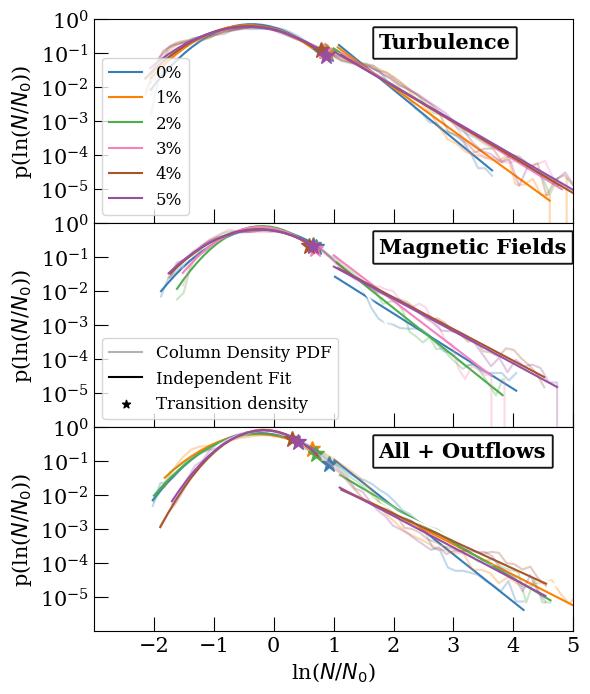

time: 5.246792840957641


In [5]:
#super combined
start = time.time()
print('starting')
percent_f = [0,1,2,3,4,5]
perc_f = ('0','1','2','3','4','5')
color_list = ('#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00')
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(6,8),sharex = 'all', sharey = 'row', gridspec_kw={'hspace': 0,'wspace':0})
ax =ax.ravel()    
for B in range(num_runs):
    if num_runs ==1:
        B =percent_case
    
    #only cell in need of changing between runs
    percent = percent_f[B]
    perc = perc_f[B]
    #only cell in need of changing between runs
    inputfile = ('/scratch/jak491/npz_storage/covering_grid_den0.npz','/scratch/jak491/npz_storage/covering_grid_den1.npz','/scratch/jak491/npz_storage/covering_grid_den2.npz', '/scratch/jak491/npz_storage/covering_grid_den3.npz', '/scratch/jak491/npz_storage/covering_grid_den4.npz', '/scratch/jak491/npz_storage/covering_grid_den5.npz', '/scratch/jak491/npz_storage/covering_grid_den_high.npz')
    titles = ('Turbulence', 'Magnetic Fields', 'All + Outflows')
    #titles = ('10% SFE\nG','10% SFE\nG+T','10% SFE\nG+T+M','6% SFE\nG+T+M+P' )
    sigma_limit = .75
    slope_limit = 1
    #define Linear function
    def linear(x, m, b): 
        return m*x + b

    #define Log Normal function
    def lognorm(x,mu,sigma):
       return np.log((1/(np.sqrt(2*np.pi*sigma**2)))*(np.exp(-((x-mu)**2)/(2*sigma**2))))

    #plot setup
    d = {}
    input_file = inputfile[percent]
    plot_data = np.load(input_file, allow_pickle=True)
    #main processing cell. 

    slopes = []
    error = []
    sigma = []
    sigma_error = []
    #plt.suptitle('Column Densities with ' + perc + '% SFE', size =26)
    #ax[0].annotate(' log upper limit = .75\n linear lower limit = 1',[-2,1e-5], size =15)

    b = 3

    for n in range(3):
        if B ==1 and n ==1 or B==3 and n==2:
            color_list = ('white', 'white', 'white','white', 'white', 'white','white', 'white', 'white')
            visible = 0
        else:
            color_list = ('#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00')
            visible = 1
        den = plot_data[plot_data.files[n+1]]
        print(n)     #for time keeping

        for a in (range(num_axis)):

            log_den_d = plot_data[plot_data.files[4+b]]
            counts_d, binS_d = np.histogram(log_den_d,bins=50, density= True)
            b = b+4-num_axis

            bin_list = []
            for i in range(len(binS_d)-1):
                bin_i=(binS_d[i]+binS_d[i+1])/2
                bin_list.append(bin_i)
            #create subrange and plots linear fit
            x =[]
            y = []
            x_log =[]
            y_log = []
            for i in range(len(bin_list)):
                if bin_list[i] > slope_limit:
                    if counts_d[i] > 0:
                            x.append(bin_list[i])
                            y.append(counts_d[i])
                    else:
                        break
            for i in range(len(bin_list)):
                if bin_list[i] < sigma_limit:
                        x_log.append(bin_list[i])
                        y_log.append(counts_d[i])
                else:
                    break

            lin_param, lin_con = scipy.optimize.curve_fit(linear, x, np.log(y))
            y = linear(np.array(x),lin_param[0],lin_param[1])

            log_param, log_con = scipy.optimize.curve_fit(lognorm, x_log, np.log(y_log))
            y_log = lognorm(np.array(x_log),log_param[0],log_param[1])

            #print( lin_param)
            slopes.append(lin_param[0])
            error.append(np.sqrt(np.diag(lin_con))[0])
            sigma.append(log_param[1])
            sigma_error.append(np.sqrt(np.diag(log_con))[1])
            #calculate and plot transition point
            trans_point =  (-lin_param[0]-.5)*log_param[1]**2
            for X in range(len(bin_list)):
                if bin_list[X] >= trans_point:
                    ax[n].plot(trans_point,counts_d[X], color = color_list[B], marker = '*', markersize = 12)
                    break
            ax[n].plot(bin_list, counts_d, color = color_list[B], alpha = .3)
            ax[n].plot(x,np.exp(y), color = color_list[B])
            ax[n].plot(x_log,np.exp(y_log), color = color_list[B])


        if n > 1:
            ax[n].set_xlabel(r'ln($N/N_0$)', size=15)
        
        ax[n].set_ylabel(r'p(ln($N/N_0$))', size=15)

        ax[n].annotate(titles[n], (1.75,.2), color = 'black', fontsize =15, weight = 'bold',horizontalalignment='left',verticalalignment='center', textcoords='data', bbox=dict(facecolor='white', alpha=0.8))
        ax[n].tick_params(direction='in', which = 'major', size =10)
        ax[n].tick_params(direction='in', which = 'minor', size =4)
        #ax[n].set_title(titles[n], size = 17)
        ax[n].set_yscale('log')
        ax[n].set_ylim(10**(-6),1)
        ax[n].set_xlim(-3,5)
        ax[n].tick_params(direction='in', length=10, labelsize = 15, which = 'major')

        ax[n].set_yticks((1e0,1e-1,1e-2,1e-3,1e-4,1e-5))
        ax[n].set_xticks((-2,-1,0,1,2,3,4,5))
        
    if num_runs ==6 and num_axis ==3:
        file = open("comb_slope_" +perc+"%.txt", "w")
        str_dictionary = repr(slopes)
        file.write(str_dictionary + "\n")
        str_dictionary = repr(error)
        file.write(str_dictionary + "\n")
        file.close()


        #write sigma and error to txt file for later
        file = open("txt_file_storage/sigma_" +perc+"%.txt", "w")
        str_dictionary = repr(sigma)
        file.write(str_dictionary + "\n")
        str_dictionary = repr(sigma_error)
        file.write(str_dictionary + "\n")
        file.close()
    
#dots in a far corner just to make legend
ax[0].plot(100,100,color = color_list[0], label ='0%')
ax[0].plot(100,100,color = color_list[1], label ='1%')
ax[0].plot(100,100,color = color_list[2], label ='2%')
ax[0].plot(100,100,color = color_list[3], label ='3%')
ax[0].plot(100,100,color = color_list[4], label ='4%')
ax[0].plot(100,100,color = color_list[5], label ='5%')
ax[0].legend(loc = 'lower left',fontsize = 12)
ax[1].scatter(100,100,color = 'black',marker = '*', label ='Transition density')
ax[1].plot(100,100,color = 'black',alpha = .3, label ='Column Density PDF')
ax[1].plot(100,100,color = 'black', label ='Independent Fit')
ax[1].legend(loc = 'lower left',fontsize = 12)

plt.tight_layout()
plt.subplots_adjust(top=.85)
if num_runs == 1:
    plt.savefig('pipeline/'+ perc +'per_pipeline/combined_col_'+ perc+'_percent.pdf', bbox_inches='tight', format = 'pdf')
else:
    plt.savefig('pipeline/combined_col_super.pdf', bbox_inches='tight', format = 'pdf')
plt.show()
end = time.time()
print("time:",(end-start)/60)

starting
0
[-0.79701699 -0.75702342 -0.61693671 ... -0.82719718 -0.8154968
 -0.79293229]
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.7529331357223003 +/- 0.01894560442748828 
 alpha= 2.966476786571219 +/- 0.08621626169289458 
 s0= -0.26751873832409373 +/- 0.01253588345374757 
 st= 1.4142015941160482 +/- 0.3806229592232054
1
[-0.82492396 -0.82492396 -0.80800426 ... -0.81248923 -0.80172663
 -0.80172663]
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.5324759959766587 +/- 0.017871597313732196 
 alpha= 3.017430489950045 +/- 0.053976928543190306 
 s0= -0.18797044842280242 +/- 0.0058804882339401395 
 st= 0.6675636892291322 +/- 0.22226380849100072
2
[-0.14115463 -0.14115463 -0.14115463 ... -0.1786749  -0.17427058
 -0.17427058]
//============Fit complete=========//
Best fit parameters: 
 sigma= 0.6150984592439517 +/- 0.01558433198437079 
 alpha= 3.0845700289285882 +/- 0.0504327445923787 
 s0= -0.19924408617448794 +/- 0.007284602086213961 
 st= 0.

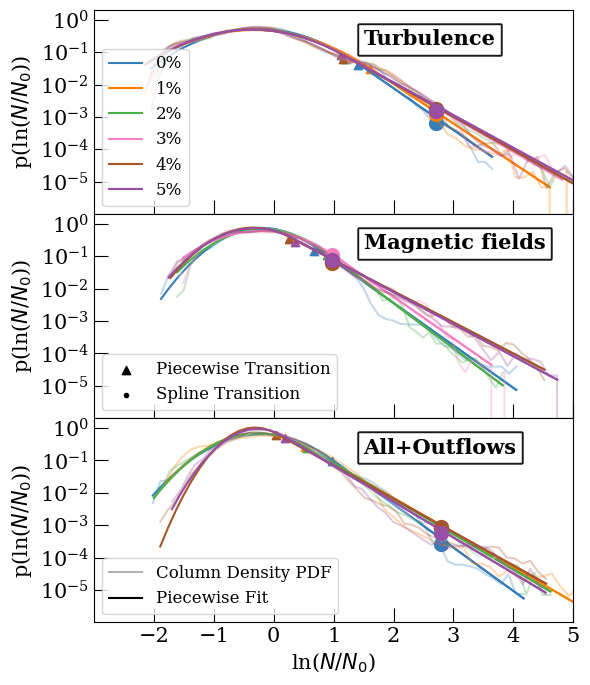

time: 5.726006384690603


In [7]:
#super plot with all snapshots
start = time.time()
print('starting')
percent_f = [0,1,2,3,4,5]
perc_f = ('0','1','2','3','4','5')
color_list = ('#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00')
fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(6,8), sharex = 'all', sharey = 'row', gridspec_kw={'hspace': 0,'wspace':0})
ax =ax.ravel()

#spline transition points
spline_inputfile = ('txt_file_storage/trans_point0%.txt','txt_file_storage/trans_point1%.txt','txt_file_storage/trans_point2%.txt','txt_file_storage/trans_point3%.txt','txt_file_storage/trans_point4%.txt','txt_file_storage/trans_point5%.txt')
spline_trans = []
sfe = range(6)
for ii in range(6):
    for a in range(1):
        #slope cutting. data from txt file chopped into usable form.
        f =open(spline_inputfile[ii])
        newlist = [i for i in f]
        string = newlist[0]
        string1 = string.split("[")[1]
        string2 = string1.split("]")[0]
        string3 = string2.split(",")
        string3 = np.array(string3)
        slope_list = string3.astype('float')
        spline_trans.append(slope_list[a])
        spline_trans.append(slope_list[3+a])
        spline_trans.append(slope_list[6+a])
for B in range(num_runs):
    if num_runs == 1:
        B = percent_case
    
    inputfile = ('/scratch/jak491/npz_storage/covering_grid_den0.npz','/scratch/jak491/npz_storage/covering_grid_den1.npz','/scratch/jak491/npz_storage/covering_grid_den2.npz', '/scratch/jak491/npz_storage/covering_grid_den3.npz', '/scratch/jak491/npz_storage/covering_grid_den4.npz', '/scratch/jak491/npz_storage/covering_grid_den5.npz', '/scratch/jak491/npz_storage/covering_grid_den_high.npz')
    percent = percent_f[B]
    perc = perc_f[B]
    titles = ('Turbulence', 'Magnetic fields', 'All+Outflows')
    slopes =[]
    slopes_error = []
    sigmas = []
    sigmas_error = []
    #titles = ('10% SFE\nG','10% SFE\nG+T','10% SFE\nG+T+M','6% SFE\nG+T+M+P' )
    sigma_limit = 1
    slope_limit = 1

    #define Linear function 
    def linear(x, m, b): 
        return m*x + b    
    #define Log Normal function
    def lognorm(x,mu,sigma):
        return np.log((1/(np.sqrt(2*np.pi*sigma**2)))*(np.exp(-((x-mu)**2)/(2*sigma**2))))

    #plot setup
    d = {}
    variable_name =('density_g','density_gt','density_gtm', 'density_gtmp')
    input_file = inputfile[percent]
    plot_data = np.load(input_file, allow_pickle=True)

    #editting the package to allow small sigma
    class Params():
        def __init__(self, root_finding_lower_lim= -15, root_finding_upper_lim=1, root_finding_step_size=0.2, \
                    root_finding_max_tries=40, s_cut_off = 10, y_min_cut_off=0, bounds = [(0,1.01,0.3,3),(5,5,5,10)],\
                    shrink_data = 4, debug=False, single_bounds=[(.1,.1),(5,5)]):

            ''' Parameters: 
            root_finding_lower_lim - This is the lower limit for the root finding range.
            root_finding_upper_lim - This is the upper limit for the root finding range.
            root_finding_step_size - This is the step_size for root finding. Range shrinks by this value after each iteration.
            root_finding_max_tries - This is the maximum number of attempts to make at root_finding.
            s_cut_off - The maximum cut-off for the x values.
            y_min_cut_off - The minimum cut-off for the y-values.
            bounds - The bounds of the parameters (double PL case).
            shrink_data - The number of data points to remove from the edges.
            debug - Flag for printing the parameter values while fitting is ongoing.
            single_bounds - The bounds of the fitted parameters (single PL case).
            '''
            self.root_finding_lower_lim=root_finding_lower_lim
            self.root_finding_upper_lim=root_finding_upper_lim
            self.root_finding_step_size=root_finding_step_size   #This means the range shrinks by 0.2 (default) everytime.
            self.root_finding_max_tries=root_finding_max_tries
            self.s_cut_off=s_cut_off
            self.y_min_cut_off=y_min_cut_off
            self.bounds = bounds
            self.shrink_data = shrink_data                       #Removing some data points from the edges helps to fit better.
            self.debug=debug
            self.single_bounds=single_bounds


    #power law fitting. 

    slopes = []
    transit =[]
    transit_error = []
    error = []
    #plt.suptitle('Column Densities with ' + perc + '% SFE', size =26)
    #ax[0].annotate(' log upper limit = .75\n linear lower limit = 1',[-2,1e-5], size =15)

    b = 3

    for n in range(3):
        if B ==1 and n ==1 or B==3 and n==2:
            color_list = ('white', 'white', 'white','white', 'white', 'white','white', 'white', 'white')
            visible = 0
        else:
            color_list = ('#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00')
            visible = 1
        den = plot_data[plot_data.files[n+1]]
        print(n)     #for time keeping

        for a in (range(num_axis)):
            #n = 1
            #a = 1
            #b = 9
            log_den_d = plot_data[plot_data.files[4+b]]
            b = b+4-num_axis
            print(log_den_d)
            counts_d, binS_d = np.histogram(log_den_d,bins=50, density= True)


            bin_list = []
            for i in range(len(binS_d)-1):
                bin_i=(binS_d[i]+binS_d[i+1])/2
                bin_list.append(bin_i)

    #######################################################################################
            #power fit specifics
            xdata = bin_list
            ydata = counts_d
            p0=[.6, 3]  #p0= (sigma, alpha)

            params = Params(s_cut_off = 6) #cut off for x, the maximum value of x
            results = PLFit(xdata, ydata, p0, params)#, use_K21=True)
            y_int = .6
            slope_limit = results.sg
            trans = results.sg
            trans_error = results.sg_err
            transit.append(trans)
            transit_error.append(trans_error)
            slope = results.alpha_g
            slopes.append(slope)
            sigma = results.sigma
            sigmas.append(sigma)
            slope_error = results.alpha_g_err
            slopes_error.append(slope_error)
            sigma_error = results.sigma_err
            sigmas_error.append(sigma_error)
    #######################################################################################


            #create subrange and plots linear fit
            x =[]
            y = []
            x_log =[]
            y_log = []
            for i in range(len(bin_list)):
                if bin_list[i] >= slope_limit:
                    if counts_d[i] > 0:
                            x.append(bin_list[i])
                            y.append(counts_d[i])
                    else:
                        break
            for i in range(len(bin_list)):
                if bin_list[i] <= x[0]:
                        x_log.append(bin_list[i])
                        y_log.append(counts_d[i])
                else:
                    break


            log_param, log_con = scipy.optimize.curve_fit(lognorm, x_log, np.log(y_log))
            y_log = lognorm(np.array(x_log),results.s0,results.sigma)
            #find y intercept
            m = -1*results.alpha_g
            x_b = x_log[len(x_log)-1]
            y_b = y_log[len(y_log)-1]
            b_log =  y_b-(m*x_b)

            y = linear(np.array(x),m,b_log)
            full_x = np.concatenate((x_log,x))
            full_y = np.concatenate((y_log,y))
            c = 0 #tells if pieceiwse transition has been plotted
            z = 0
            for X in full_x:
                if X >= spline_trans[b] and c ==0:  #plot piecewise points
                    ax[n].plot(spline_trans[b],np.exp(full_y[z]),color = color_list[B], marker = '.', markersize =20,alpha = visible) #plot transition point
                    c = 1
                z = z+1
            ax[n].plot(x,np.exp(y), color = color_list[B],alpha = visible)
            ax[n].plot(x_log,np.exp(y_log), color = color_list[B],alpha = visible)
            ax[n].plot(bin_list, counts_d, color = color_list[B], alpha = .3)
            ax[n].plot(x,np.exp(y), color = color_list[B],alpha = visible)
            ax[n].scatter(trans,np.exp(y[0]), color = color_list[B], marker = '^',alpha = visible)



        if n > 1:
            ax[n].set_xlabel(r'ln($N/N_0$)', size=15)
       
        ax[n].set_ylabel(r'p(ln($N/N_0$))', size=15)


        ax[n].annotate(titles[n], (1.5,.25), color = 'black', fontsize =15, weight = 'bold',horizontalalignment='left',verticalalignment='center', textcoords='data', bbox=dict(facecolor='white', alpha=0.8))

        #ax[n].set_title(titles[n], size = 17)
        ax[n].tick_params(direction='in', length=6, size = 10, labelsize = 14)
        ax[n].set_yscale('log')
        ax[n].set_ylim(10**(-6),2)
        ax[n].set_xlim(-3,5)
        ax[n].tick_params(direction='in', length=10, labelsize = 15, which = 'major')

        ax[n].set_xticks((-2,-1,0,1,2,3,4,5))
        ax[n].set_yticks((1e0,1e-1,1e-2,1e-3,1e-4,1e-5))

    if num_runs ==6 and num_axis ==3:
        file = open("txt_file_storage/power_fit_slope" +perc+"%.txt", "w")
        str_dictionary = repr(slopes)
        file.write(str_dictionary + "\n")
        str_dictionary = repr(slopes_error)
        file.write(str_dictionary + "\n")
        file.close()

        file = open("txt_file_storage/power_fit_sigma" +perc+"%.txt", "w")
        str_dictionary = repr(sigmas)
        file.write(str_dictionary + "\n")
        str_dictionary = repr(sigmas_error)
        file.write(str_dictionary + "\n")
        file.close()

        file = open("txt_file_storage/trans_density" +perc+"%.txt", "w")
        str_dictionary = repr(transit)
        file.write(str_dictionary + "\n")
        str_dictionary = repr(transit_error)
        file.write(str_dictionary + "\n")
        file.close()
    
#create legend with off screen points
ax[0].plot(100,100,color = color_list[0], label ='0%')
ax[0].plot(100,100,color = color_list[1], label ='1%')
ax[0].plot(100,100,color = color_list[2], label ='2%')
ax[0].plot(100,100,color = color_list[3], label ='3%')
ax[0].plot(100,100,color = color_list[4], label ='4%')
ax[0].plot(100,100,color = color_list[5], label ='5%')
ax[0].legend(loc = 'lower left',fontsize = 12)
ax[1].scatter(100,100,color = 'black',marker = '^', label ='Piecewise Transition')
ax[1].scatter(100,100,color = 'black',marker = '.', label ='Spline Transition')
ax[1].legend(loc = 'lower left',fontsize = 12)
ax[2].plot(100,100,color = 'black',alpha = .3, label ='Column Density PDF')
ax[2].plot(100,100,color = 'black', label ='Piecewise Fit')
ax[2].legend(loc = 'lower left',fontsize = 12)

plt.tight_layout()
plt.subplots_adjust(top=.85)
if num_runs == 1:
    plt.savefig('pipeline/'+ perc +'per_pipeline/PLFit_col_'+ perc+'_percent.pdf', bbox_inches='tight', format = 'pdf')
else:
    plt.savefig('pipeline/PLFit_col_super.pdf', bbox_inches='tight', format = 'pdf')
plt.show()
#np.savez('plots/counts_bins_1%_turb',bin_list=bin_list,counts_d=counts_d)
end = time.time()
print("time:",(end-start)/60)

starting
0
1
2
[-3.683552008988547, -3.2585685495629586, -3.4219574694149926, -4.325989008640724, -5.442093241637385, -5.487597087078983, -4.142194956628115, -3.260493886207695, -4.1149176594968875]
starting
0
1
2
[-3.9744733196766644, -2.8210395002181334, -2.9446421264130427, -6.5919400335352805, 100, -3.824666131624814, 100, -3.607269546972803, 100, -4.010799770025275]
starting
0
1
2
[-2.7869332628038057, -3.0228835131284306, -3.014308016476472, -3.8259528519337223, -4.258484497171922, -4.596472281497234, -3.094358596538354, -2.9949712626266036, -2.938227311496269]
starting
0
1
2
[-1.6274227545895594, -3.125546017821076, -3.5363968634290743, -5.443324292546435, -2.759629352559089, -4.704645816251805, -3.2207170678295722, -3.365887391817633, -3.1795902586564484]
starting
0
1
2
[-3.4908216098763263, -3.004760006857494, -3.714559835677802, -2.7040939327911255, -2.543974663950123, -3.017393114970838, -3.546622090540558, -3.907112207267505, -3.989399763652165]
starting
0
1
2
[-3.202337723

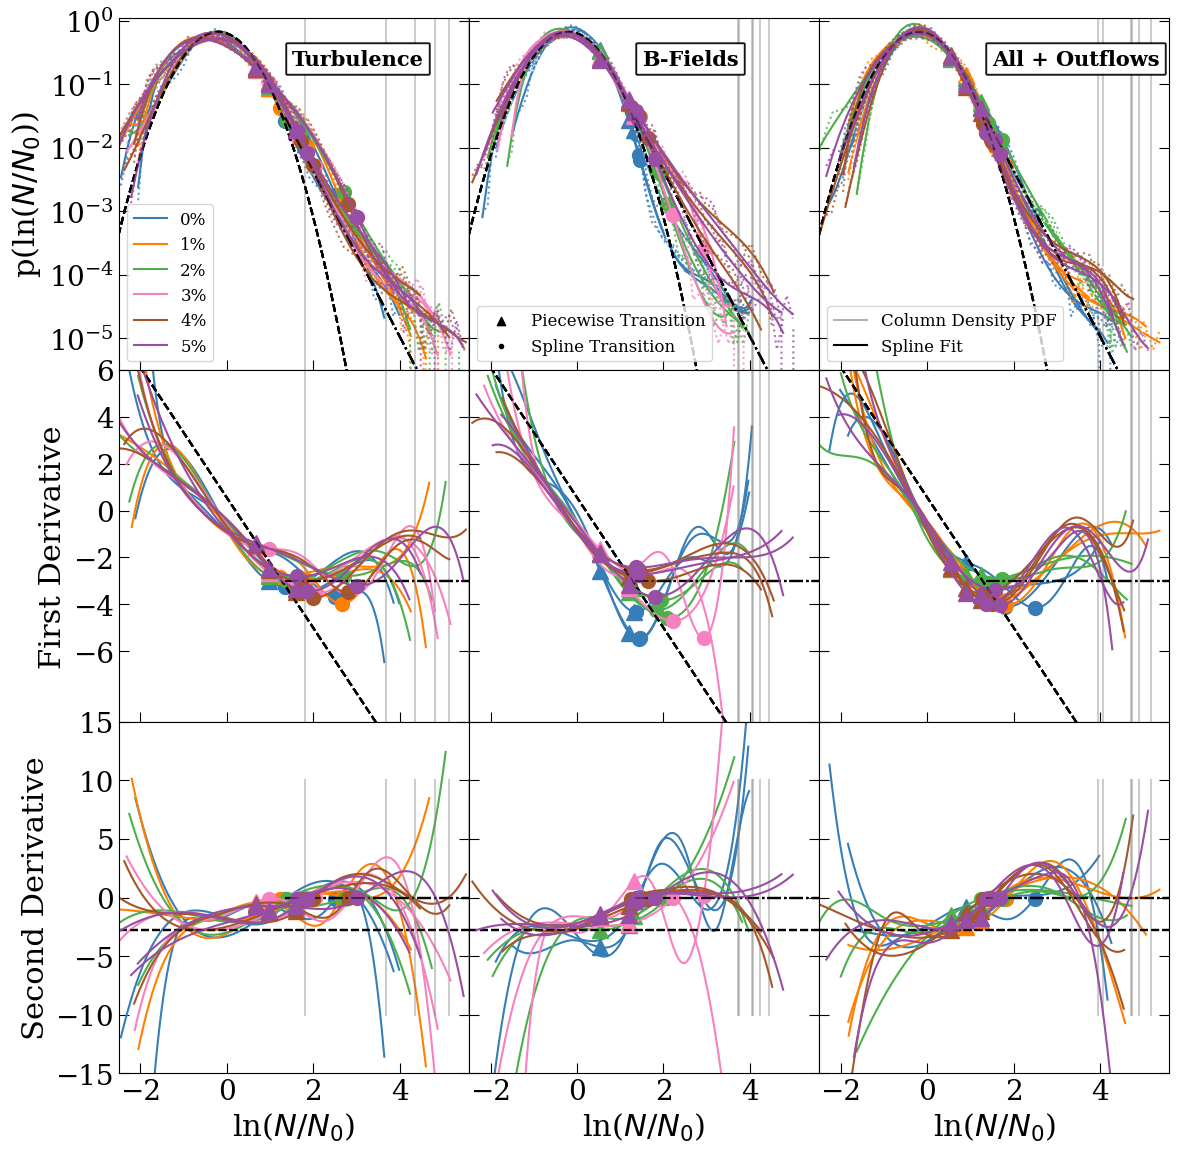

2nd check
time: 1.0490435083707175


In [13]:
#super spline
trans_start = -.1
percent_f = [0,1,2,3,4,5]
perc_f = ('0','1','2','3','4','5')
inputfile = ('/scratch/jak491/npz_storage/covering_grid_den0.npz','/scratch/jak491/npz_storage/covering_grid_den1.npz','/scratch/jak491/npz_storage/covering_grid_den2.npz', '/scratch/jak491/npz_storage/covering_grid_den3.npz', '/scratch/jak491/npz_storage/covering_grid_den4.npz', '/scratch/jak491/npz_storage/covering_grid_den5.npz', '/scratch/jak491/npz_storage/covering_grid_den_high.npz')
color_list = ('#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00')
#piecewise transition points
piece_inputfile = ('txt_file_storage/trans_density0%.txt','txt_file_storage/trans_density1%.txt','txt_file_storage/trans_density2%.txt','txt_file_storage/trans_density3%.txt','txt_file_storage/trans_density4%.txt','txt_file_storage/trans_density5%.txt')
piecewise_trans = []
sfe = range(6)
for ii in range(6):
    for a in range(1):
        #slope cutting. data from txt file chopped into usable form.
        f =open(piece_inputfile[ii])
        newlist = [i for i in f]
        string = newlist[0]
        string1 = string.split("[")[1]
        string2 = string1.split("]")[0]
        string3 = string2.split(",")
        string3 = np.array(string3)
        slope_list = string3.astype('float')
        piecewise_trans.append(slope_list[a])
        piecewise_trans.append(slope_list[3+a])
        piecewise_trans.append(slope_list[6+a])
#line_list = ()'''
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(12,12),sharex = 'all', sharey = 'row', gridspec_kw={'hspace': 0,'wspace':0})
ax =ax.ravel()    
for B in range(num_runs):
    if num_runs == 1:
        B =percent_case
    #only cell in need of changing between runs
    percent = percent_f[B]
    perc = perc_f[B]
    #titles = ('10% SFE\nG','10% SFE\nG+T','10% SFE\nG+T+M','6% SFE\nG+T+M+P' )
    #define Log Normal function
    def lognorm(x,mu,sigma):
       return np.log((1/(np.sqrt(2*np.pi*sigma**2)))*(np.exp(-((x-mu)**2)/(2*sigma**2))))
    def lognorm_deriv1(x,mu,sigma):
       return (-x-mu)/sigma**2
    def linear_ex(x_linear):
        return -3.5
    sigma = .6
    mu = -.2
    x_example = np.linspace(-3,6,num=100)
    y_ex = lognorm(x_example,mu,sigma)
    y_example = np.exp(y_ex)
    y_log_deriv1 = lognorm_deriv1(x_example,mu,sigma)
    y_log_deriv2 = np.ones(len(x_example))*(-1/sigma**2)

    #power law!
    def power_ex(x_power, slope_example,m):
        return m*(x_power)**slope_example
    y_int = .03
    x_start = 1.35
    slope_example = -3.0
    m = y_int/(np.exp(x_start)**slope_example)
    #what I plot
    x_power = np.linspace(x_start,6,num=1000)
    e_x_power = np.exp(x_power)
    y_power = power_ex(e_x_power,slope_example,m)
    #derivatives

    y_power_1st = np.ones(len(x_power))*slope_example
    y_power_2nd = np.zeros(len(x_power))

    #plot setup
    titles = ( 'Turbulence','B-Fields', 'All + Outflows')

    d = {}
    variable_name =('density_g','density_gt','density_gtm', 'density_gtmp')
    input_file = inputfile[percent]
    plot_data = np.load(input_file, allow_pickle=True)

    #main processing cell
    warnings.filterwarnings('ignore')


    start = time.time()
    print('starting')
    spline_slope = []
    slopes = []
    error = []
    trans_point = []

    #plt.suptitle('Column Densities and Spline with ' + perc + '% SFE', size =30)
    b = 3
    ax[0].plot(100,100, color = color_list[0], alpha =1)
    ax[0].plot(100,100, color = color_list[1], alpha =1)
    ax[0].plot(100,100, color = color_list[2], alpha =1)
    #ax[0].plot(100,100, color = 'black', alpha =.5)


    #legend1 = ax[0].legend([ 'x', 'y', 'z'], loc = 'upper right', fontsize = 20)

    #leg4 =ax[0].plot(100,100, color = 'black', alpha =.3)
    #leg5 =ax[0].plot(100,100, color = 'black', alpha =1, linestyle = ':')
    #legend2 = ax[0].legend([leg4,leg5],['column density','spline fit'], loc = 'lower right')
    #ax[0].add_artist(legend1)
    num_loop = 0 #records which specific column density we are on
    for n in range(3):   #physics cases
        if B ==1 and n ==1 or B==3 and n==2:
            color_list = ('white', 'white', 'white','white', 'white', 'white','white', 'white', 'white')
            visible = 0
        else:
            color_list = ('#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00')
            visible = 1
        den = plot_data[plot_data.files[n+1]]
        print(n)     #for time keeping\
        

        for a in (range(num_axis)):
            xx =[]
            y = []
            spline = []
            z_check = 1
            log_den_d = plot_data[plot_data.files[4+b]]
            counts_d, binS_d = np.histogram(log_den_d,bins=50, density= True)
            b = b+4-num_axis

            bin_list = []
            for i in range(len(binS_d)-1):
                bin_i=(binS_d[i]+binS_d[i+1])/2
                bin_list.append(bin_i)

            for i in range(len(bin_list)):

                if counts_d[i] > 0:
                        xx.append(bin_list[i])
                        y.append(counts_d[i])
                else:
                    break
            x = np.linspace(min(xx), max(xx), 500)
            counts_filtered = savgol_filter(np.log(y), 17, 3) #(np.log(y), window length (odd number), power of polynomial)

            spl = UnivariateSpline(xx, counts_filtered, k = 5, s = .3)  #k is degree of polynomial
            pdf_density_fit = x
            pdf_counts_fit = np.exp(spl(x))
            ax[n].plot(bin_list, counts_d, color = color_list[B], alpha = .8, linestyle = ':')
            ax[n].plot(xx, np.exp(spl(xx)), color =color_list[B],alpha = visible)
            #overplot example curve and its derivatives
            ax[n].plot(x_example,y_example, color = 'black', alpha = .3,linestyle = '--')
            ax[n+3].plot(x_example,y_log_deriv1, color = 'black', alpha = .3, linestyle = '--')
            ax[n+6].plot(x_example,y_log_deriv2, color = 'black', alpha = .3, linestyle = '--')

            deriv = spl.derivative(1)
            first_deriv = deriv(x)
            pdf_counts_deriv = deriv(x)
            ax[n+3].plot(x, first_deriv,color =color_list[B],alpha = visible)
        #example_1st_deriv = deriv(x_example)
        #ax[n+4].plot(x_example,example_1st_deriv, color = 'black',alpha = .5)
            #second derivative
            deriv_2 = spl.derivative(2)
            second_deriv = deriv_2(x)

            ax[n+6].plot(x, second_deriv,color =color_list[B],alpha = visible)

            #overplot power law example
            ax[n].plot(x_power,y_power, color = 'black', alpha = .3,linestyle = '-.')
            ax[n+3].plot(x_power,y_power_1st, color = 'black', alpha = .3,linestyle = '-.')
            ax[n+6].plot(x_power,y_power_2nd, color = 'black', alpha = .3,linestyle = '-.')
            #set transition cutoff lower if gravity case, due to no power law
            if n == 0:
                trans_cutoff = .9
            else:
                trans_cutoff = 1
    #recording spline transition point
            z = 0
            c = 0 #tells if pieceiwse transition has been plotted
            d =0

            for X in x:
                if X >= piecewise_trans[b-3] and c ==0:  #plot piecewise points
                    ax[n].plot(piecewise_trans[b-3],np.exp(spl(x[z])),color = color_list[B], marker = '^', markersize =12,alpha = visible) #plot transition point
                    ax[n+3].plot(piecewise_trans[b-3],first_deriv[z],color = color_list[B], marker = '^', markersize =12,alpha = visible) #plot transition point
                    ax[n+6].plot(piecewise_trans[b-3],second_deriv[z],color = color_list[B], marker = '^', markersize =12,alpha = visible) #plot transition point
                    c = 1

                if percent == 1 and n ==2 and d==0:
                    spline_slope.append(100)
                    trans_point.append(100)
                    d=1
                    '''if X > trans_cutoff:
                        if X < 2:
                            spline.append(pdf_counts_deriv[z])
                        if second_deriv[z]>0:
                            if len(trans_point) <= num_loop:
                                trans_point.append(x[z])
                                print('confirmed')  #(3/(2/((-1)*pdf_counts_deriv[z])+1))
                                ax[n].plot(x[z],np.exp(spl(x[z])),color = color_list[B], marker = '.', markersize =20,alpha = visible) #plot transition point
                                ax[n+3].plot(x[z],first_deriv[z],color = color_list[B], marker = '.', markersize =20,alpha = visible) #plot transition point
                                ax[n+6].plot(x[z],second_deriv[z],color = color_list[B], marker = '.', markersize =20,alpha = visible) #plot transition point
'''

                #recording spline transition point 
                else:
                    if X > trans_cutoff:
                        if second_deriv[z-1]<trans_start:
                            if second_deriv[z]>trans_start:
                                trans_point.append(x[z])
                                #puts dots on transition point, where slope is recorded
                                ax[n].plot(x[z],np.exp(spl(x[z])),color = color_list[B], marker = '.', markersize =20,alpha = visible) #plot transition point
                                ax[n+3].plot(x[z],first_deriv[z],color = color_list[B], marker = '.', markersize =20,alpha = visible) #plot transition point
                                ax[n+6].plot(x[z],second_deriv[z],color = color_list[B], marker = '.', markersize =20,alpha = visible) #plot transition point
                                #can be editted to get slope from average of several points instead of single point
                                #avg_slope = sum(pdf_counts_deriv[z])/len(pdf_counts_deriv[z])  
                                avg_slope = pdf_counts_deriv[z]
                                #print('2D slope', pdf_counts_deriv[z])
                                #print('3D slope',3/(2/((-1)*avg_slope)+1))
                                #print('trans point',x[z])
                                spline_slope.append(avg_slope)
                                break
                z = z+1
            if len(spline) > 0: 
                spline_slope.append(sum(spline)/len(spline))


            #recording spline slope
            #spline_slope.append(first_deriv[z])
            num_loop = num_loop + 1





        #if n > 1:
        ax[n+6].set_xlabel(r'ln($N/N_0$)', size=22)
        #if n == 0 or n == 2:
        ax[0].set_ylabel(r'p(ln($N/N_0$))', size=22)
        ax[3].set_ylabel(r'First Derivative', size=22)
        ax[6].set_ylabel(r'Second Derivative', size=22)

      #  if n == 0 or n == 2:
      #     ax[n+4].set_ylabel(r'p(ln($N/N_0$))', size=15)
        #add in theoretical transition density
        trans_theory = (-1*spline_slope[n]-.5)*1.27**2 #using equation 8 from Appel et al 2020
        trans_theory = np.ones(2)*trans_theory
        trans_theory_y = [-10,10]
        ax[n].plot(trans_theory,trans_theory_y, color = 'gray', alpha =.4)
        ax[n+3].plot(trans_theory,trans_theory_y, color = 'gray', alpha =.4)
        ax[n+6].plot(trans_theory,trans_theory_y, color = 'gray', alpha =.4)


        ax[n].annotate(titles[n], (1.5,.25), color = 'black', fontsize =15, weight = 'bold',horizontalalignment='left',verticalalignment='center', textcoords='data', bbox=dict(facecolor='white', alpha=0.8))
        #ax[n+4].annotate(titles[n],[-2,-6.5], size =15)
        ax[n].set_yscale('log')
        #ax[n].set_xscale('log')
        #ax[n].set_ylim(10**(-6),1)
        #ax[n].set_xlim(-3,6)
        ax[n].tick_params(direction='in', length=7, labelsize = 20, which = 'major')
        ax[n].tick_params(direction='in', length=3, labelsize = 20, which = 'minor')
        ax[n+3].tick_params(direction='in', length=7, labelsize = 20, which = 'major')
        ax[n+3].tick_params(direction='in', length=3, labelsize = 20, which = 'minor')
        ax[n+6].tick_params(direction='in', length=7, labelsize = 20, which = 'major')
        ax[n+6].tick_params(direction='in', length=3, labelsize = 20, which = 'minor')
        ax[n].tick_params(direction='in', length=7, labelsize = 20, which = 'major',right = True)
        ax[n].tick_params(direction='in', length=3, labelsize = 20, which = 'minor',right = True)
        ax[n+3].tick_params(direction='in', length=7, labelsize = 20, which = 'major',right = True)
        ax[n+3].tick_params(direction='in', length=3, labelsize = 20, which = 'minor',right = True)
        ax[n+6].tick_params(direction='in', length=7, labelsize = 20, which = 'major',right = True)
        ax[n+6].tick_params(direction='in', length=3, labelsize = 20, which = 'minor',right = True)
        ax[n].set_yticks((1e0,1e-1,1e-2,1e-3,1e-4,1e-5))
        ax[n+3].set_yscale('linear')
        ax[n].set_ylim(10**(-5.5),1.1)
        ax[n+3].set_ylim(-9,6)
        ax[n+6].set_ylim(-15,15)

        ax[n].set_xlim(-2.5,5.6)
        ax[n+3].set_xlim(-2.5,5.6)
        ax[n+6].set_xlim(-2.5,5.6)

        ax[n+3].set_yticks((6,4,2,0,-2,-4,-6))
        #if n >0:
        ax[n+6].set_xticks((-2,0,2,4))
    #ax[8].set_xticks((-2.5,0,2.5,5))

    if num_runs == 6 and num_axis == 3:
        file = open("txt_file_storage/spline_slope" +perc+"%.txt", "w")
        str_dictionary = repr(spline_slope)
        file.write(str_dictionary + "\n")
        #str_dictionary = repr(slopes_error)
        #file.write(str_dictionary + "\n")
        file.close()
        print(spline_slope)

        file = open("txt_file_storage/trans_point" +perc+"%.txt", "w")
        str_dictionary = repr(trans_point)
        file.write(str_dictionary + "\n")
        file.close()

#dots in a far corner just to make legend
ax[0].plot(100,100,color = color_list[0], label ='0%')
ax[0].plot(100,100,color = color_list[1], label ='1%')
ax[0].plot(100,100,color = color_list[2], label ='2%')
ax[0].plot(100,100,color = color_list[3], label ='3%')
ax[0].plot(100,100,color = color_list[4], label ='4%')
ax[0].plot(100,100,color = color_list[5], label ='5%')
ax[0].legend(loc = 'lower left',fontsize = 12)
ax[1].scatter(100,100,color = 'black',marker = '^', label ='Piecewise Transition')
ax[1].scatter(100,100,color = 'black',marker = '.', label ='Spline Transition')
ax[1].legend(loc = 'lower left',fontsize = 12)
ax[2].plot(100,100,color = 'black',alpha = .3, label ='Column Density PDF')
ax[2].plot(100,100,color = 'black', label ='Spline Fit')
ax[2].legend(loc = 'lower left',fontsize = 12)
plt.tight_layout()
plt.subplots_adjust(top=.95)
if num_runs == 1:
    plt.savefig('pipeline/'+ perc +'per_pipeline/spline_col_'+ perc+'_percent.pdf', bbox_inches='tight', format = 'pdf')
else:
    plt.savefig('pipeline/spline_col_super.pdf', bbox_inches='tight', format = 'pdf')
plt.show()

print('2nd check')
end = time.time()
print("time:",(end-start)/60)

starting
0
50 50
41 41
//============Fit complete=========//
Best fit parameters: 
 sigma= 1.4879345178025956 +/- 0.029347072668871037 
 alpha= 1.8548941684477294 +/- 0.027739818019427306 
 s0= -1.083943323108911 +/- 0.041117209405124665 
 st= 3.0226980060110513 +/- 0.8189699639140443
1
50 50
44 44
//============Fit complete=========//
Best fit parameters: 
 sigma= 1.2740719800659877 +/- 0.04993506058120414 
 alpha= 2.1184987923343583 +/- 0.04998000447633846 
 s0= -0.7792326168041804 +/- 0.05992079214288508 
 st= 2.659640483750863 +/- 0.9680703665043336
2
50 50
42 42
//============Fit complete=========//
Best fit parameters: 
 sigma= 1.4371402694038307 +/- 0.022690084523090157 
 alpha= 1.9988438109747992 +/- 0.019914533770667604 
 s0= -0.9942622018344786 +/- 0.031121715116631726 
 st= 3.134094145432409 +/- 0.7354131967553871
starting
0
50 50
42 42
//============Fit complete=========//
Best fit parameters: 
 sigma= 1.491126605917001 +/- 0.038588561700647755 
 alpha= 1.7857250358751104 +

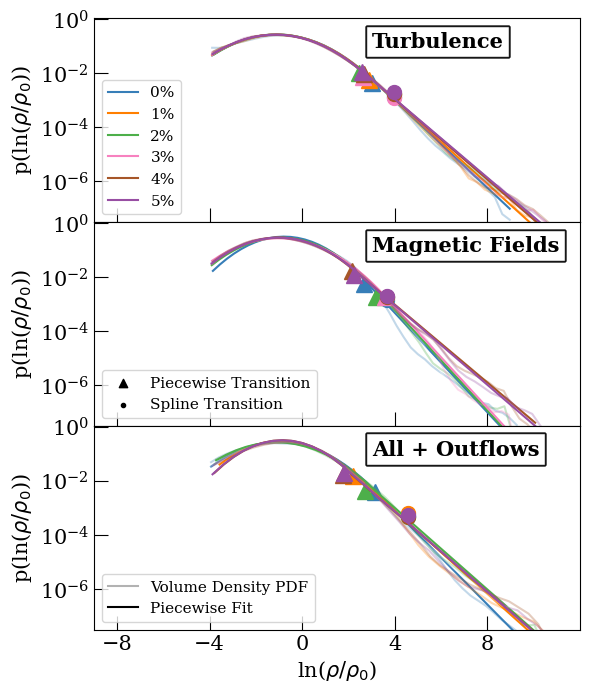

time: 0.03483834266662598


In [6]:
###all setup condensed to one block. no need to rerun between trials
#only cell in need of changing between runs
percent_f = [0,1,2,3,4,5]
perc_f = ('0','1','2','3','4','5')
color_list = ('#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00')

fig, ax = plt.subplots(nrows=3,ncols=1,figsize=(6,8), sharex = 'all', sharey = 'row', gridspec_kw={'hspace': 0,'wspace':0})

ax =ax.ravel()
inputfile = ('/scratch/jak491/npz_storage/vol_covering_grid_den0.npz','/scratch/jak491/npz_storage/vol_covering_grid_den1.npz','/scratch/jak491/npz_storage/vol_covering_grid_den2.npz', '/scratch/jak491/npz_storage/vol_covering_grid_den3.npz', '/scratch/jak491/npz_storage/vol_covering_grid_den4.npz', '/scratch/jak491/npz_storage/vol_covering_grid_den5.npz', '/scratch/jak491/npz_storage/vol_covering_grid_den_high.npz')
spline_inputfile = ('txt_file_storage/vol_trans_point0%.txt','txt_file_storage/vol_trans_point1%.txt','txt_file_storage/vol_trans_point2%.txt','txt_file_storage/vol_trans_point3%.txt','txt_file_storage/vol_trans_point4%.txt','txt_file_storage/vol_trans_point5%.txt')
#import spline transition densities
spline_trans = []
sfe = range(6)
for ii in range(6):
    #slope cutting. data from txt file chopped into usable form.
    f =open(spline_inputfile[ii])
    newlist = [i for i in f]
    string = newlist[0]
    string1 = string.split("[")[1]
    string2 = string1.split("]")[0]
    string3 = string2.split(",")
    string3 = np.array(string3)
    slope_list = string3.astype('float')
    spline_trans.append(slope_list[0])
    spline_trans.append(slope_list[1])
    spline_trans.append(slope_list[2])
for B in range(num_runs):
    if num_runs ==1:
        B = percent_case
    percent = percent_f[B]
    perc = perc_f[B]
    titles = ('Turbulence', 'Magnetic Fields', 'All + Outflows')
    slopes =[]
    slopes_error = []
    sigmas = []
    sigmas_error = []
    #titles = ('10% SFE\nG','10% SFE\nG+T','10% SFE\nG+T+M','6% SFE\nG+T+M+P' )
    sigma_limit = 1
    slope_limit = 1

    #define Linear function 
    def linear(x, m, b): 
        return m*x + b    
    #define Log Normal function
    def lognorm(x,mu,sigma):
        return np.log((1/(np.sqrt(2*np.pi*sigma**2)))*(np.exp(-((x-mu)**2)/(2*sigma**2))))

    #plot setup
    d = {}
    variable_name =('density_g','density_gt','density_gtm', 'density_gtmp')
    input_file = inputfile[percent]
    plot_data = np.load(input_file, allow_pickle=True)

    
    #power law fitting. 
    start = time.time()
    print('starting')
    slopes = []
    transit =[]
    transit_error = []
    error = []
    
    #plt.suptitle('Column Densities with ' + perc + '% SFE', size =26)
    #ax[0].annotate(' log upper limit = .75\n linear lower limit = 1',[-2,1e-5], size =15)


    b = 0

    for n in range(3):
        if B ==1 and n ==1 or B==3 and n==2:
            color_list = ('white', 'white', 'white','white', 'white', 'white','white', 'white', 'white')
            visible = 0
        else:
            color_list = ('#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00')
            visible = 1
        den = plot_data[plot_data.files[n+1]]
        print(n)     #for time keeping

        for a in (range(1)):
            #load in  histrogram data, fully ready to plot
            bin_list = plot_data[plot_data.files[n+1]]
            counts_d = plot_data[plot_data.files[n+5]]
            print(len(bin_list),len(counts_d))
    #######################################################################################
            #editting the package to allow small sigma
            s_cut = max(bin_list)
            class Params():
                def __init__(self, root_finding_lower_lim= -15, root_finding_upper_lim=1, root_finding_step_size=0.2, \
                            root_finding_max_tries=40, s_cut_off = s_cut, y_min_cut_off=0, bounds = [(0,1.01,0.3,3),(5,5,5,10)],\
                            shrink_data = 4, debug=False, single_bounds=[(.1,.1),(5,5)]):

                    ''' Parameters: 
                    root_finding_lower_lim - This is the lower limit for the root finding range.
                    root_finding_upper_lim - This is the upper limit for the root finding range.
                    root_finding_step_size - This is the step_size for root finding. Range shrinks by this value after each iteration.
                    root_finding_max_tries - This is the maximum number of attempts to make at root_finding.
                    s_cut_off - The maximum cut-off for the x values.
                    y_min_cut_off - The minimum cut-off for the y-values.
                    bounds - The bounds of the parameters (double PL case).
                    shrink_data - The number of data points to remove from the edges.
                    debug - Flag for printing the parameter values while fitting is ongoing.
                    single_bounds - The bounds of the fitted parameters (single PL case).
                    '''
                    self.root_finding_lower_lim=root_finding_lower_lim
                    self.root_finding_upper_lim=root_finding_upper_lim
                    self.root_finding_step_size=root_finding_step_size   #This means the range shrinks by 0.2 (default) everytime.
                    self.root_finding_max_tries=root_finding_max_tries
                    self.s_cut_off=s_cut_off
                    self.y_min_cut_off=y_min_cut_off
                    self.bounds = bounds
                    self.shrink_data = shrink_data                       #Removing some data points from the edges helps to fit better.
                    self.debug=debug
                    self.single_bounds=single_bounds

            #create cutoff
            bins = []
            counts = []
            for L in range(len(bin_list)):
                if bin_list[L] > -4:
                    bins.append(bin_list[L])
                    counts.append(counts_d[L])
            bin_list = bins
            #power fit specifics
            xdata = bin_list
            ydata = counts
            ydata = np.array(ydata)
            p0=[1.27, 3]        #p0= (sigma, alpha)
            print(len(xdata),len(ydata))

            params = Params(s_cut_off = s_cut) #cut off for x, the maximum value of x
            results = PLFit(xdata, ydata, p0, params)#, use_K21=True)
            y_int = .6
            sigma_limit = results.sg
            slope_limit = results.sg
            trans = results.sg
            trans_error = results.sg_err
            transit.append(trans)
            transit_error.append(trans_error)
            slope = results.alpha_g
            slopes.append(slope)
            sigma = results.sigma
            sigmas.append(sigma)
            slope_error = results.alpha_g_err
            slopes_error.append(slope_error)
            sigma_error = results.sigma_err
            sigmas_error.append(sigma_error)
            #create subrange and plots linear fit
            x =[]
            y = []
            x_log =[]
            y_log = []
            for i in range(len(bin_list)):
                if bin_list[i] >= slope_limit:
                    if counts[i] > 0:
                            x.append(bin_list[i])
                            y.append(counts[i])
                    else:
                        break
            for i in range(len(bin_list)):
                if bin_list[i] <= x[0]:
                        x_log.append(bin_list[i])
                        y_log.append(counts[i])
                else:
                    break


            log_param, log_con = scipy.optimize.curve_fit(lognorm, x_log, np.log(y_log))
            y_log = lognorm(np.array(x_log),results.s0,results.sigma)
            #find y intercept
            m = -1*results.alpha_g
            x_b = x_log[len(x_log)-1]
            y_b = y_log[len(y_log)-1]
            b_log =  y_b-(m*x_b)
            y = linear(np.array(x),m,b_log)
            
            full_y = np.concatenate((y_log,y))
            c = 0 #tells if pieceiwse transition has been plotted
            z = 0
            for X in bin_list:
                if X >= spline_trans[b] and c ==0:  #plot piecewise points
                    ax[n].plot(spline_trans[b],np.exp(full_y[z]),color = color_list[B], marker = '.', markersize =20,alpha = visible) #plot transition point
                    c = 1
                    b = b+1
                z = z+1
            ax[n].plot(x,np.exp(y), color = color_list[B],alpha = visible)
            ax[n].plot(x_log,np.exp(y_log), color = color_list[B],alpha = visible)
            ax[n].plot(trans,np.exp(y[0]), color = color_list[B], marker = '^', markersize =12,alpha = visible)

            ax[n].plot(bin_list, counts, color = color_list[B], alpha = .3)



        if n > 1:
            ax[n].set_xlabel(r'ln($\rho/\rho_0$)', size=15)
       
        ax[n].set_ylabel(r'p(ln($\rho/\rho_0$))', size=15)


        ax[n].annotate(titles[n], (3,.15), color = 'black', fontsize =15, weight = 'bold',horizontalalignment='left',verticalalignment='center', textcoords='data', bbox=dict(facecolor='white', alpha=0.8))

        #ax[n].set_title(titles[n], size = 17)
        ax[n].tick_params(direction='in', length=6, size = 10, labelsize = 14)
        ax[n].set_yscale('log')
        ax[n].set_ylim(10**(-7.5),1.1)
        ax[n].set_xlim(-9,12)
        ax[n].tick_params(direction='in', length=10, labelsize = 15, which = 'major')

        ax[n].set_xticks((-8,-4,0,4,8))
        ax[n].set_yticks((1e0,1e-2,1e-4,1e-6))

    if num_runs == 6:
        file = open("txt_file_storage/vol_power_fit_slope" +perc+"%.txt", "w")
        str_dictionary = repr(slopes)
        file.write(str_dictionary + "\n")
        str_dictionary = repr(slopes_error)
        file.write(str_dictionary + "\n")
        file.close()

        file = open("txt_file_storage/vol_power_fit_sigma" +perc+"%.txt", "w")
        str_dictionary = repr(sigmas)
        file.write(str_dictionary + "\n")
        str_dictionary = repr(sigmas_error)
        file.write(str_dictionary + "\n")
        file.close()

        file = open("txt_file_storage/vol_trans_density" +perc+"%.txt", "w")
        str_dictionary = repr(transit)
        file.write(str_dictionary + "\n")
        str_dictionary = repr(transit_error)
        file.write(str_dictionary + "\n")
        file.close()
#create legend with off screen points
ax[0].plot(100,100,color = color_list[0], label ='0%')
ax[0].plot(100,100,color = color_list[1], label ='1%')
ax[0].plot(100,100,color = color_list[2], label ='2%')
ax[0].plot(100,100,color = color_list[3], label ='3%')
ax[0].plot(100,100,color = color_list[4], label ='4%')
ax[0].plot(100,100,color = color_list[5], label ='5%')
ax[0].legend(loc = 'lower left',fontsize = 11)
ax[1].scatter(100,100,color = 'black',marker = '^', label ='Piecewise Transition')
ax[1].scatter(100,100,color = 'black',marker = '.', label ='Spline Transition')
ax[1].legend(loc = 'lower left',fontsize = 11)
ax[2].plot(100,100,color = 'black',alpha = .3, label ='Volume Density PDF')
ax[2].plot(100,100,color = 'black', label ='Piecewise Fit')
ax[2].legend(loc = 'lower left',fontsize = 11)


plt.tight_layout()
plt.subplots_adjust(top=.85)
if num_runs == 1:
    plt.savefig('pipeline/'+ perc +'per_pipeline/PLF_vol_'+ perc+'_percent.pdf', bbox_inches='tight', format = 'pdf')
else:
    plt.savefig('pipeline/PLF_super_vol.pdf', bbox_inches='tight', format = 'pdf')
plt.show()

end = time.time()
print("time:",(end-start)/60)

starting
0
1
2
starting
0
1% slope
1
1% slope
2
1% slope
starting
0
1
2
starting
0
1
2
starting
0
1
2
starting
0
1
2


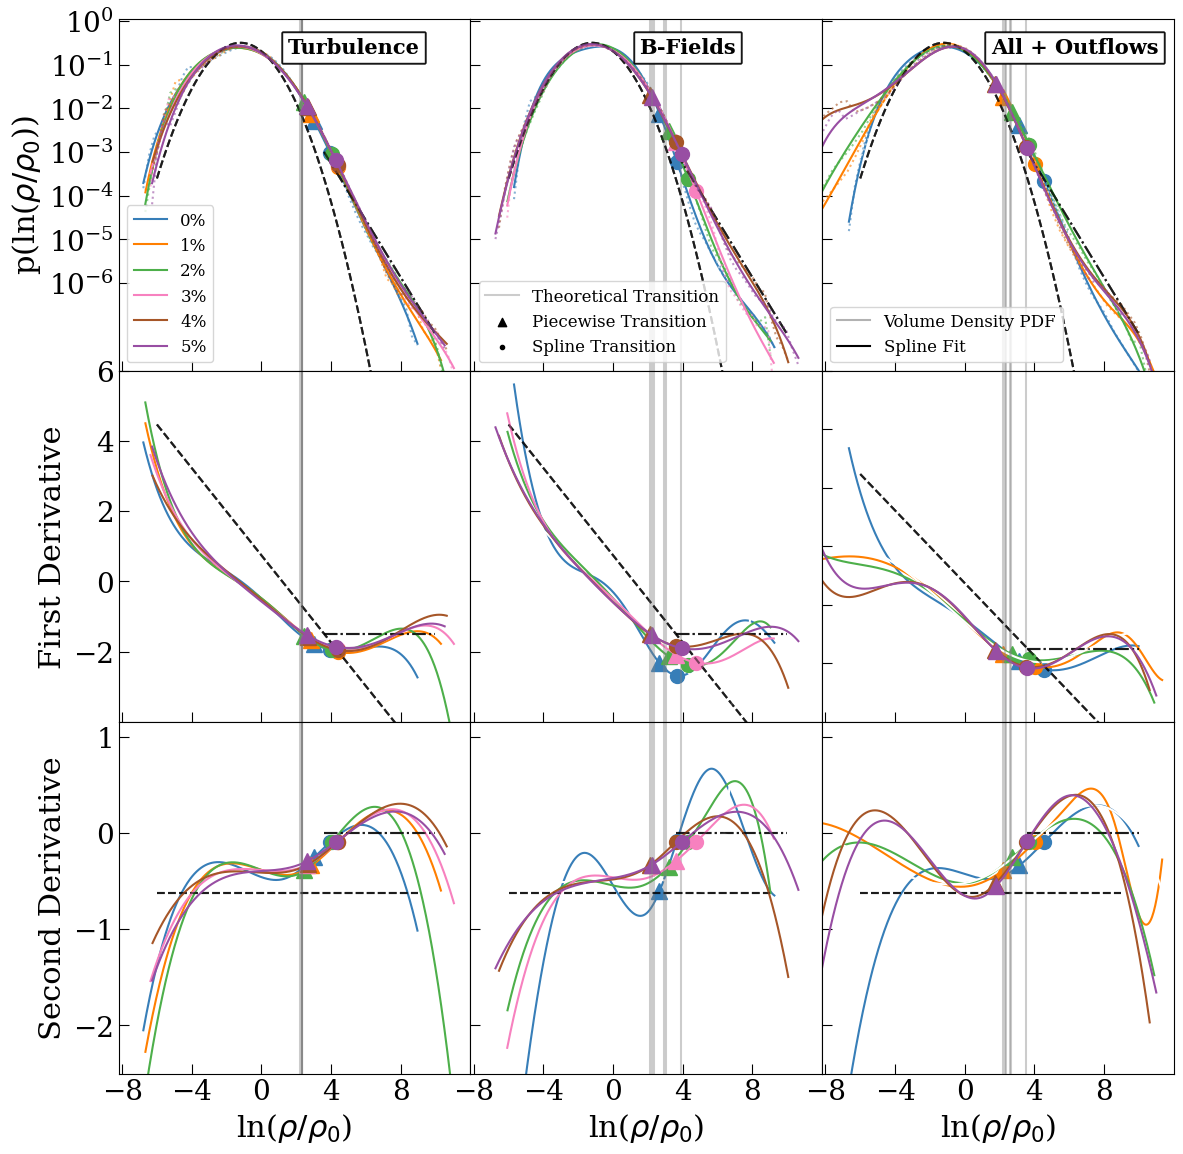

time: 0.1148790160814921


In [4]:
#super plot with all axis and transition point
trans_start = -.1
percent_f = [0,1,2,3,4,5]
perc_f = ('0','1','2','3','4','5')
color_list = ('#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00')
fig, ax = plt.subplots(nrows=3,ncols=3,figsize=(12,12),sharex = 'all', sharey = 'row', gridspec_kw={'hspace': 0,'wspace':0})
ax =ax.ravel()
piece_inputfile = ('txt_file_storage/vol_trans_density0%.txt','txt_file_storage/vol_trans_density1%.txt','txt_file_storage/vol_trans_density2%.txt','txt_file_storage/vol_trans_density3%.txt','txt_file_storage/vol_trans_density4%.txt','txt_file_storage/vol_trans_density5%.txt')
#import piecewise transition densities
piecewise_trans = []
sfe = range(6)
for ii in range(6):
    #slope cutting. data from txt file chopped into usable form.
    f =open(piece_inputfile[ii])
    newlist = [i for i in f]
    string = newlist[0]
    string1 = string.split("[")[1]
    string2 = string1.split("]")[0]
    string3 = string2.split(",")
    string3 = np.array(string3)
    slope_list = string3.astype('float')
    piecewise_trans.append(slope_list[0])
    piecewise_trans.append(slope_list[1])
    piecewise_trans.append(slope_list[2])
    

b = 0
for B in range(num_runs):
    if num_runs == 1:
        B = percent_case
    #only cell in need of changing between runs
    inputfile = ('/scratch/jak491/npz_storage/vol_covering_grid_den0.npz','/scratch/jak491/npz_storage/vol_covering_grid_den1.npz','/scratch/jak491/npz_storage/vol_covering_grid_den2.npz', '/scratch/jak491/npz_storage/vol_covering_grid_den3.npz', '/scratch/jak491/npz_storage/vol_covering_grid_den4.npz', '/scratch/jak491/npz_storage/vol_covering_grid_den5.npz', '/scratch/jak491/npz_storage/vol_covering_grid_den_high.npz')
    percent = percent_f[B]
    perc = perc_f[B]

    #define Log Normal function
    def lognorm(x,mu,sigma):
       return np.log((1/(np.sqrt(2*np.pi*sigma**2)))*(np.exp(-((x-mu)**2)/(2*sigma**2))))
    def lognorm_deriv1(x,mu,sigma):
       return (-x-mu)/sigma**2
    def linear_ex(x_linear):
        return -3.5
    sigma = 1.27
    mu = -1.2
    x_example = np.linspace(-6,9,num=100)
    y_ex = lognorm(x_example,mu,sigma)
    y_example = np.exp(y_ex)
    y_log_deriv1 = lognorm_deriv1(x_example,mu,sigma)
    y_log_deriv2 = np.ones(len(x_example))*(-1/sigma**2)

    #power law!
    def power_ex(x_power, slope_example,m):
        return m*(x_power)**slope_example
    y_int = .001
    x_start = 3.6
    slope_example = -1.5
    m = y_int/(np.exp(x_start)**slope_example)
    #what I plot
    x_power = np.linspace(x_start,10,num=1000)
    e_x_power = np.exp(x_power)
    y_power = power_ex(e_x_power,slope_example,m)
    #derivatives
    y_power_1st = np.ones(len(x_power))*slope_example
    y_power_2nd = np.zeros(len(x_power))

    #plot setup
    titles = ('Turbulence','B-Fields', 'All + Outflows')
    d = {}
    variable_name =('density_gt','density_gtm', 'density_gtmp')
    input_file = inputfile[percent]
    plot_data = np.load(input_file, allow_pickle=True)

    #main processing cell
    warnings.filterwarnings('ignore')
    start = time.time()
    print('starting')
    spline_slope = []
    slopes = []
    error = []
    trans_point = []
    breaker = 0

    num_loop = 0 #records which specific column density we are on
    for n in range(3):   #n sets physics case
        if B ==1 and n ==1 or B==3 and n==2:
            color_list = ('white', 'white', 'white','white', 'white', 'white','white', 'white', 'white')
            visible = 0
        else:
            color_list = ('#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00')
            visible = 1
        den = plot_data[plot_data.files[n+1]]
        print(n)     #for time keeping

        for a in (range(1)):   #a determines axis, which is 1 for volume density
            xx =[]
            y = []
            spline = []
            z_check = 1
            #load in  histrogram data, fully ready to plot
            bin_list = plot_data[plot_data.files[n+1]]
            counts_d = plot_data[plot_data.files[n+5]]
            for i in range(len(bin_list)):
                if counts_d[i] > 0:
                        xx.append(bin_list[i])
                        y.append(counts_d[i])
                else:
                    break
            x = np.linspace(min(xx), max(xx), 500)
            counts_filtered = savgol_filter(np.log(y), 17, 3) #(np.log(y), window length (odd number), power of polynomial)

            spl = UnivariateSpline(xx, counts_filtered, k = 5, s = .3) #k is the polynomial degree
            pdf_density_fit = x
            pdf_counts_fit = np.exp(spl(x))
            ax[n].plot(bin_list, counts_d, color = color_list[B], alpha = .6, linestyle = ':')
            ax[n].plot(x, np.exp(spl(x)) , color =color_list[B],alpha = visible)
            #overplot example curve and its derivatives
            ax[n].plot(x_example,y_example, color = 'black', alpha = .3,linestyle = '--')
            ax[n+3].plot(x_example,y_log_deriv1, color = 'black', alpha = .3, linestyle = '--')
            ax[n+6].plot(x_example,y_log_deriv2, color = 'black', alpha = .3, linestyle = '--')

            deriv = spl.derivative(1)
            first_deriv = deriv(x)
            pdf_counts_deriv = deriv(x)
            ax[n+3].plot(x, first_deriv ,color =color_list[B])
        #example_1st_deriv = deriv(x_example)
        #ax[n+4].plot(x_example,example_1st_deriv, color = 'black',alpha = .5)
            #second derivative
            deriv_2 = spl.derivative(2)
            second_deriv = deriv_2(x)
            ax[n+6].plot(x, second_deriv,color =color_list[B])

            #overplot power law example
            ax[n].plot(x_power,y_power, color = 'black', alpha = .3,linestyle = '-.')
            ax[n+3].plot(x_power,y_power_1st, color = 'black', alpha = .3,linestyle = '-.')
            ax[n+6].plot(x_power,y_power_2nd, color = 'black', alpha = .3,linestyle = '-.')
            #
    #recording spline transition point
            z = 0
            c = 0 #tells if pieceiwse transition has been plotted

            for X in x:
                if X >= piecewise_trans[b] and c ==0:  #plot piecewise points
                    ax[n].plot(piecewise_trans[b],np.exp(spl(x[z])),color = color_list[B], marker = '^', markersize =12,alpha = visible) #plot transition point
                    ax[n+3].plot(piecewise_trans[b],first_deriv[z],color = color_list[B], marker = '^', markersize =12,alpha = visible) #plot transition point
                    ax[n+6].plot(piecewise_trans[b],second_deriv[z],color = color_list[B], marker = '^', markersize =12,alpha = visible) #plot transition point
                    c = 1
                if percent == 1 or percent ==2 and n ==3:

                    if X > 3:
                        if X < 7:
                            spline.append(pdf_counts_deriv[z])
                        if second_deriv[z]>trans_start:
                            if len(trans_point) <= num_loop:
                                trans_point.append(x[z])
                                ax[n].plot(x[z],np.exp(spl(x[z])) ,color = color_list[B], marker = '.', markersize =20) #plot transition point
                                ax[n+3].plot(x[z],first_deriv[z],color = color_list[B], marker = '.', markersize =20) #plot transition point
                                ax[n+6].plot(x[z],second_deriv[z],color = color_list[B], marker = '.', markersize =20) #plot transition point


                #recording spline transition point 
                else:
                    if X > 0:
                        if second_deriv[z-1]<trans_start:
                            if second_deriv[z]>trans_start:
                                trans_point.append(x[z])
                                spline_slope.append(pdf_counts_deriv[z])
                                ax[n].plot(x[z],np.exp(spl(x[z])) ,color = color_list[B], marker = '.', markersize =20,alpha = visible) #plot transition point
                                ax[n+3].plot(x[z],first_deriv[z],color = color_list[B], marker = '.', markersize =20,alpha = visible) #plot transition point
                                ax[n+6].plot(x[z],second_deriv[z],color = color_list[B], marker = '.', markersize =20,alpha = visible) 
                                break
                z = z+1
            if len(spline) > 0:  
                spline_slope.append(sum(spline)/len(spline))
                print('1% slope')
            if percent ==0:
                if n ==0:
                    zz=0
                    for Z in second_deriv:
                        if breaker == 0:
                            if Z> -.003:
                                spline_slope.append(pdf_counts_deriv[zz])
                                breaker =1
                            zz= zz+1



            #recording spline slope
            #spline_slope.append(first_deriv[z])
            num_loop = num_loop + 1

        #add in theoretical transition density
        trans_theory = (-1*spline_slope[n]-.5)*1.27**2 #using equation 8 from Appel et al 2020
        trans_theory = np.ones(2)*trans_theory
        trans_theory_y = [-10,10]
        ax[n].plot(trans_theory,trans_theory_y, color = 'gray', alpha =.4)
        ax[n+3].plot(trans_theory,trans_theory_y, color = 'gray', alpha =.4)
        ax[n+6].plot(trans_theory,trans_theory_y, color = 'gray', alpha =.4)

        #if n > 1:
        ax[n+6].set_xlabel(r'ln($\rho/\rho_0$)', size=22)
        #if n == 0 or n == 2:
        ax[0].set_ylabel(r'p(ln($\rho/\rho_0$))', size=22)
        ax[3].set_ylabel(r'First Derivative', size=22)
        ax[6].set_ylabel(r'Second Derivative', size=22)
        ax[n].annotate(titles[n], (1.5,.25), color = 'black', fontsize =15, weight = 'bold',horizontalalignment='left',verticalalignment='center', textcoords='data', bbox=dict(facecolor='white', alpha=0.8))
        ax[n].set_yscale('log')
        ax[n].tick_params(direction='in', length=7, labelsize = 20, which = 'major')
        ax[n].tick_params(direction='in', length=3, labelsize = 20, which = 'minor')
        ax[n+3].tick_params(direction='in', length=7, labelsize = 20, which = 'major')
        ax[n+3].tick_params(direction='in', length=3, labelsize = 20, which = 'minor')
        ax[n+6].tick_params(direction='in', length=7, labelsize = 20, which = 'major')
        ax[n+6].tick_params(direction='in', length=3, labelsize = 20, which = 'minor')
        #'''
        if n == 3:
            ax[n].tick_params(direction='in', length=7, labelsize = 20, which = 'major',right = True)
            ax[n].tick_params(direction='in', length=3, labelsize = 20, which = 'minor',right = True)
            ax[n+3].tick_params(direction='in', length=7, labelsize = 20, which = 'major',right = True)
            ax[n+3].tick_params(direction='in', length=3, labelsize = 20, which = 'minor',right = True)
            ax[n+6].tick_params(direction='in', length=7, labelsize = 20, which = 'major',right = True)
            ax[n+6].tick_params(direction='in', length=3, labelsize = 20, which = 'minor',right = True)

        ax[n].set_yticks((1e0,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6))
        ax[n+3].set_yscale('linear')
        ax[n].set_ylim(10**(-8),1.1)
        ax[n+3].set_ylim(-4,6)
        ax[n+6].set_ylim(-2.5,1.15)

        ax[n].set_xlim(-8.2,12)
        ax[n+3].set_xlim(-8.2,12)
        ax[n+6].set_xlim(-8.2,12)

        ax[n+3].set_yticks((8,6,4,2,0,-2))
        #if n >0:
        ax[n+6].set_xticks((-8,-4,0,4,8))
        #counter
        b = b+1
    #ax[8].set_xticks((-2.5,0,2.5,5))
    if num_runs == 6:
        file = open("txt_file_storage/vol_spline_slope" +perc+"%.txt", "w")
        str_dictionary = repr(spline_slope)
        file.write(str_dictionary + "\n")
        #str_dictionary = repr(slopes_error)
        #file.write(str_dictionary + "\n")
        file.close()

        file = open("txt_file_storage/vol_trans_point" +perc+"%.txt", "w")
        str_dictionary = repr(trans_point)
        file.write(str_dictionary + "\n")
        file.close()

    #np.savez('vol_counts_bins_1%_outflow',bin_list=bin_list,counts_d=counts_d)

#dots in a far corner just to make legend
ax[0].plot(100,100,color = color_list[0], label ='0%')
ax[0].plot(100,100,color = color_list[1], label ='1%')
ax[0].plot(100,100,color = color_list[2], label ='2%')
ax[0].plot(100,100,color = color_list[3], label ='3%')
ax[0].plot(100,100,color = color_list[4], label ='4%')
ax[0].plot(100,100,color = color_list[5], label ='5%')
ax[0].legend(loc = 'lower left',fontsize = 12)
ax[1].scatter(100,100,color = 'black',marker = '^', label ='Piecewise Transition')
ax[1].scatter(100,100,color = 'black',marker = '.', label ='Spline Transition')
ax[1].plot(100,100,color = 'gray',alpha = .4, label ='Theoretical Transition')
ax[1].legend(loc = 'lower left',fontsize = 12)
ax[2].plot(100,100,color = 'black',alpha = .3, label ='Volume Density PDF')
ax[2].plot(100,100,color = 'black', label ='Spline Fit')
ax[2].legend(loc = 'lower left',fontsize = 12)

plt.tight_layout()
plt.subplots_adjust(top=.95)
if num_runs == 1:
    plt.savefig('pipeline/'+ perc +'per_pipeline/spline_vol_'+ perc+'_percent.pdf', bbox_inches='tight', format = 'pdf')
else:
    plt.savefig('pipeline/spline_super_vol.pdf', bbox_inches='tight', format = 'pdf')
plt.show()

end = time.time()
print("time:",(end-start)/60)

In [11]:
spline_slope

[-1.857138834769731, -1.8985473884963053, -2.1597158805219467]

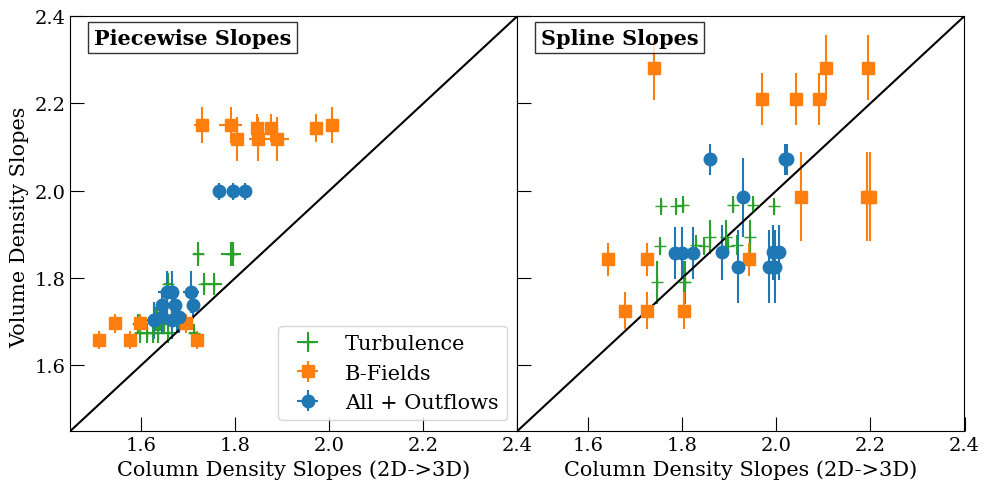

In [12]:
#produce analysis plots comparing slopes
#get the slopes from the volume density file from Sabrina
inputfile = ('slopes_3D.npz')
plot_data = np.load(inputfile, allow_pickle=True)
slopes = plot_data['ave_slopes']
grav_3D_vol = -1*slopes[0:6]
turbulence_3D_vol = -1*slopes[7:13]
mag_3D_vol = -1*slopes[14:20]
outflows_3D_vol = -1*slopes[21:27]
error_3D = plot_data['err_slopes']
grav_err_vol = error_3D[0:6]
turbulence_err_vol = error_3D[7:13]
mag_err_vol = error_3D[14:20]
outflows_err_vol = error_3D[21:27]
#load in 2D slopes to be organized
inputfile = ('txt_file_storage/slope_0%_lim1.txt','txt_file_storage/slope_1%_lim1.txt','txt_file_storage/slope_2%_lim1.txt','txt_file_storage/slope_3%_lim1.txt','txt_file_storage/slope_4%_lim1.txt','txt_file_storage/slope_5%_lim1.txt')
for a in range(1):
    slope_x_g = []
    slope_x_gt = []
    slope_x_gtm = []
    slope_x_gtmp = []
    error_x_g = []
    error_x_gt = []
    error_x_gtm = []
    error_x_gtmp = []
    sfe = range(6)
    for ii in range(6):
        #slope cutting. data from txt file chopped into usable form.
        f =open(inputfile[ii])
        newlist = [i for i in f]
        string = newlist[0]
        string1 = string.split("[")[1]
        string2 = string1.split("]")[0]
        string3 = string2.split(",")
        string3 = np.array(string3)
        slope_list = string3.astype('float')
        slope_x_gt.append((-1)*slope_list[0+a])
        if ii == 1: #remove trouble case
            slope_x_gtm.append(100)
        else:
            slope_x_gtm.append((-1)*slope_list[3+a])
        if ii == 3: #remove trouble case
            slope_x_gtmp.append(100)
        else:
            slope_x_gtmp.append((-1)*slope_list[6+a])      
        #error bars
        f =open(inputfile[ii])
        newlist = [i for i in f]
        string = newlist[1]
        string1 = string.split("[")[1]
        string2 = string1.split("]")[0]
        string3 = string2.split(",")
        string3 = np.array(string3)
        slope_list = string3.astype('float')
        error_x_gt.append(slope_list[0+a])
        error_x_gtm.append(slope_list[3+a])
        error_x_gtmp.append(slope_list[6+a])
#spline version of 3D plot

'''fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5),sharex = 'all', sharey = 'row', gridspec_kw={'hspace': 0,'wspace':0})
ax =ax.ravel()'''
axis = ['x-axis','y-axis','z-axis']
spline_comparison_g = []
spline_comparison_gt = []
spline_comparison_gtm = []
spline_comparison_gtmp = []
spline_2D_slope_full_g = []
spline_2D_slope_full_gt = []
spline_2D_slope_full_gtm = []
spline_2D_slope_full_gtmp = []

#load in 2D slopes to be organized
inputfile = ('txt_file_storage/spline_slope0%.txt','txt_file_storage/spline_slope1%.txt','txt_file_storage/spline_slope2%.txt','txt_file_storage/spline_slope3%.txt','txt_file_storage/spline_slope4%.txt','txt_file_storage/spline_slope5%.txt')
for a in range(3):
    spline_slope_x_g = []
    spline_slope_x_gt = []
    spline_slope_x_gtm = []
    spline_slope_x_gtmp = []

    sfe = range(6)
    for ii in range(6):
        #slope cutting. data from txt file chopped into usable form.
        f =open(inputfile[ii])
        newlist = [i for i in f]
        string = newlist[0]
        string1 = string.split("[")[1]
        string2 = string1.split("]")[0]
        string3 = string2.split(",")
        string3 = np.array(string3)
        slope_list = string3.astype('float')
        spline_slope_x_gt.append((-1)*slope_list[0+a])
        if ii == 1: #remove trouble case
            spline_slope_x_gtm.append(100)
        else:
            spline_slope_x_gtm.append((-1)*slope_list[3+a])
        if ii == 3: #remove trouble case
            spline_slope_x_gtmp.append(100)
        else:
            spline_slope_x_gtmp.append((-1)*slope_list[6+a]) 
        spline_2D_slope_full_gt.append(spline_slope_x_gt)
        spline_2D_slope_full_gtm.append(spline_slope_x_gtm)
        spline_2D_slope_full_gtmp.append(spline_slope_x_gtmp)
    turbulence_3D_col_spline = np.zeros(6)
    mag_3D_col_spline = np.zeros(6)
    outflows_3D_col_spline = np.zeros(6)
    x=.1*np.linspace(0,90)
    y=x
    
    for z in range(6):
        turbulence_3D_col_spline[z] = 3/(2/spline_slope_x_gt[z]+1)
        mag_3D_col_spline[z] = 3/(2/spline_slope_x_gtm[z]+1)
        outflows_3D_col_spline[z] = 3/(2/spline_slope_x_gtmp[z]+1)
        spline_comparison_gt.append(turbulence_3D_col_spline[z])
        spline_comparison_gtm.append(mag_3D_col_spline[z])
        spline_comparison_gtmp.append(outflows_3D_col_spline[z])
    '''#plot comparisons of 2D and 3D
    ax[a].errorbar(turbulence_3D_col_spline,turbulence_3D_vol,color = 'C2',yerr = turbulence_err_vol, fmt = '+', markersize = 9)
    ax[a].errorbar(mag_3D_col_spline,mag_3D_vol,color = 'C1',yerr = mag_err_vol, fmt = 's', markersize = 9)
    ax[a].errorbar(outflows_3D_col_spline,outflows_3D_vol,color = 'C0',yerr = outflows_err_vol, fmt = 'o', markersize = 9)
    ax[a].errorbar(mag_3D_col_spline[1],mag_3D_vol[1],color = 'black', fmt = '.', markersize = 9)

    #plot bells and whistles
    if a == 0:
        ax[0].legend([ 'Turbulence', 'B field', 'Outflows'], loc = 'lower right',fontsize = 15)
    #plot x = y line
    ax[a].plot(x,y, color = 'black')
    #plt.title('3D slopes', size = 15)
    ax[a].set_xlabel('Column Density Slopes (2D->3D)', size=17)
    ax[0].set_ylabel('Volume Density Slopes ', size=17)
    ax[a].set_ylim(1,2.75)
    ax[a].set_xlim(1.0,2.75)
    ax[a].annotate(axis[a], (2.2,2.6), color = 'black', fontsize =15, weight = 'bold',horizontalalignment='left',verticalalignment='center', textcoords='data', bbox=dict(facecolor='white', alpha=0.8))
    ax[0].annotate('Spline Slopes', (1.15,2.6), color = 'black', fontsize =15, weight = 'bold',horizontalalignment='left',verticalalignment='center', textcoords='data', bbox=dict(facecolor='white', alpha=0.8))
    ax[a].set_xticks((1.4,1.6,1.8,2.0,2.2,2.4))
    ax[a].tick_params(direction='in', which = 'major', size =10,labelsize = 14)
    ax[a].tick_params(direction='in', which = 'minor', size =4)
#plt.legend(['volume slope gravity', 'column converted slope gravity', 'volume slope turbulence', 'column converted slope turbulence','volume slope magnetic', 'column converted slope magnetic', 'volume slope outflows', 'column converted slope outflows'])
plt.tight_layout()
#plt.savefig('plots/3D_slope_comparison_spline.pdf', bbox_inches='tight', format = 'pdf')'''

#piecewise 3D comparision
#convert 2D column density slopes to 3D
'''fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5),sharex = 'all', sharey = 'row', gridspec_kw={'hspace': 0,'wspace':0})
ax =ax.ravel()'''
axis = ['x-axis','y-axis','z-axis']
piece_comparison_g = []
piece_comparison_gt = []
piece_comparison_gtm = []
piece_comparison_gtmp = []
piece_comparison_err_g = []
piece_comparison_err_gt = []
piece_comparison_err_gtm = []
piece_comparison_err_gtmp = []
piece_2D_slope_full_g = []
piece_2D_slope_full_gt = []
piece_2D_slope_full_gtm = []
piece_2D_slope_full_gtmp = []
def convert(slope):
    return [-i for i in slope]
#load in 2D slopes to be organized
inputfile = ('txt_file_storage/power_fit_slope0%.txt','txt_file_storage/power_fit_slope1%.txt','txt_file_storage/power_fit_slope2%.txt','txt_file_storage/power_fit_slope3%.txt','txt_file_storage/power_fit_slope4%.txt','txt_file_storage/power_fit_slope5%.txt')
for a in range(3):
    slope_x_g = []
    slope_x_gt = []
    slope_x_gtm = []
    slope_x_gtmp = []
    error_x_g = []
    error_x_gt = []
    error_x_gtm = []
    error_x_gtmp = []
    sfe = range(6)
    for ii in range(6):
        #slope cutting. data from txt file chopped into usable form.
        f =open(inputfile[ii])
        newlist = [i for i in f]
        string = newlist[0]
        string1 = string.split("[")[1]
        string2 = string1.split("]")[0]
        string3 = string2.split(",")
        string3 = np.array(string3)
        slope_list = string3.astype('float')
        slope_x_gt.append((1)*slope_list[0+a])
        if ii == 1:
            slope_x_gtm.append(100)
        else:
            slope_x_gtm.append((1)*slope_list[3+a])
        if ii == 3:
            slope_x_gtmp.append(100)
        else:
            slope_x_gtmp.append((1)*slope_list[6+a])
        piece_2D_slope_full_gt.append(slope_x_gt)
        piece_2D_slope_full_gtm.append(slope_x_gtm)
        piece_2D_slope_full_gtmp.append(slope_x_gtmp)
        #error bars
        f =open(inputfile[ii])
        newlist = [i for i in f]
        string = newlist[1]
        string1 = string.split("[")[1]
        string2 = string1.split("]")[0]
        string3 = string2.split(",")
        string3 = np.array(string3)
        slope_list = string3.astype('float')
        error_x_gt.append(slope_list[0+a])
        error_x_gtm.append(slope_list[3+a])
        error_x_gtmp.append(slope_list[6+a])
    grav_3D_col_piece = np.zeros(6)
    turbulence_3D_col_piece = np.zeros(6)
    mag_3D_col_piece = np.zeros(6)
    outflows_3D_col_piece = np.zeros(6)
    error_3D_g_piece = np.zeros(6)
    error_3D_gt_piece = np.zeros(6)
    error_3D_gtm_piece = np.zeros(6)
    error_3D_gtmp_piece = np.zeros(6)
    x=.1*np.linspace(0,90)
    y=x

    for z in range(6):
        turbulence_3D_col_piece[z] = 3/(2/slope_x_gt[z]+1)
        mag_3D_col_piece[z] = 3/(2/slope_x_gtm[z]+1)
        outflows_3D_col_piece[z] = 3/(2/slope_x_gtmp[z]+1)
        error_3D_gt_piece[z] = (6/(slope_x_gt[z]+2)**2)*error_x_gt[z]
        error_3D_gtm_piece[z] = (6/(slope_x_gtm[z]+2)**2)*error_x_gtm[z]
        error_3D_gtmp_piece[z] = (6/(slope_x_gtmp[z]+2)**2)*error_x_gtmp[z]
        
        #for comparison
        piece_comparison_gt.append(turbulence_3D_col_piece[z])
        piece_comparison_gtm.append(mag_3D_col_piece[z])
        piece_comparison_gtmp.append(outflows_3D_col_piece[z])
        piece_comparison_err_gt.append(error_3D_gt_piece[z])
        piece_comparison_err_gtm.append(error_3D_gtm_piece[z])
        piece_comparison_err_gtmp.append(error_3D_gtmp_piece[z])
    #load in piecewise volume slopes
    inputfile2= ('txt_file_storage/vol_power_fit_slope0%.txt','txt_file_storage/vol_power_fit_slope1%.txt','txt_file_storage/vol_power_fit_slope2%.txt','txt_file_storage/vol_power_fit_slope3%.txt','txt_file_storage/vol_power_fit_slope4%.txt','txt_file_storage/vol_power_fit_slope5%.txt')
    slope_volPDF_g = []
    slope_volPDF_gt = []
    slope_volPDF_gtm = []
    slope_volPDF_gtmp = []
    err_volPDF_g = []
    err_volPDF_gt = []
    err_volPDF_gtm = []
    err_volPDF_gtmp = []

    sfe = range(6)
    for ii in range(6):
        #slope cutting. data from txt file chopped into usable form.
        f =open(inputfile2[ii])
        newlist = [i for i in f]
        string = newlist[0]
        string1 = string.split("[")[1]
        string2 = string1.split("]")[0]
        string3 = string2.split(",")
        string3 = np.array(string3)
        slope_list = string3.astype('float')
        slope_volPDF_gt.append((1)*slope_list[0])
        if ii == 1:
            slope_volPDF_gtm.append(100)
        else:
            slope_volPDF_gtm.append((1)*slope_list[1])
        if ii == 3:
            slope_volPDF_gtmp.append(100)
        else:
            slope_volPDF_gtmp.append((1)*slope_list[2])
        #again, but for errorbars
        f =open(inputfile2[ii])
        newlist = [i for i in f]
        string = newlist[1]
        string1 = string.split("[")[1]
        string2 = string1.split("]")[0]
        string3 = string2.split(",")
        string3 = np.array(string3)
        slope_list = string3.astype('float')
        err_volPDF_gt.append(slope_list[0])
        err_volPDF_gtm.append(slope_list[1])
        err_volPDF_gtmp.append(slope_list[2])
'''    #plot comparisons of 2D and 3D
    ax[a].errorbar(turbulence_3D_col_piece,slope_volPDF_gt,color = 'C2',xerr=error_3D_gt_piece,yerr = err_volPDF_gt, fmt = '+', markersize = 9)
    ax[a].errorbar(mag_3D_col_piece,slope_volPDF_gtm,color = 'C1',xerr=error_3D_gtm_piece,yerr = err_volPDF_gtm, fmt = 's', markersize = 9)
    ax[a].errorbar(outflows_3D_col_piece,slope_volPDF_gtmp,color = 'C0', xerr=error_3D_gtmp_piece,yerr = err_volPDF_gtmp, fmt = 'o', markersize = 9)
    ax[a].errorbar(mag_3D_col_piece[1],slope_volPDF_gtm[1],color = 'black', fmt = '.', markersize = 9)    
    #plot bells and whistles
    if a == 0:
        ax[0].legend(['Turbulence', 'B field', 'Outflows'], loc = 'lower right',fontsize = 15)
    #plot x = y line
    ax[a].plot(x,y, color = 'black')
    ax[a].set_xlabel('Column Density Slopes (2D->3D)', size=15)
    ax[0].set_ylabel('Volume Density Slopes ', size=15)
    ax[a].set_ylim(1.4,2.25)
    ax[a].set_xlim(1.4,2.25)
    ax[a].annotate(axis[a], (2,1.8), color = 'black', fontsize =15, weight = 'bold',horizontalalignment='left',verticalalignment='center', textcoords='data', bbox=dict(facecolor='white', alpha=0.8))
    ax[0].annotate('Piecewise Slopes', (1.42,2), color = 'black', fontsize =15, weight = 'bold',horizontalalignment='left',verticalalignment='center', textcoords='data', bbox=dict(facecolor='white', alpha=0.8))
    #ax[a].set_xticks((1.4,1.6,1.8,2.0,2.2,2.4))
    ax[a].tick_params(direction='in', which = 'major', size =10,labelsize = 14)
    ax[a].tick_params(direction='in', which = 'minor', size =4)
#plt.legend(['volume slope gravity', 'column converted slope gravity', 'volume slope turbulence', 'column converted slope turbulence','volume slope magnetic', 'column converted slope magnetic', 'volume slope outflows', 'column converted slope outflows'])
plt.tight_layout()'''
#plt.savefig('plots/3D_slope_comparison_PDFit.pdf', bbox_inches='tight', format = 'pdf')

#load in volume densities that I made
inputfile = ('txt_file_storage/vol_spline_slope0%.txt','txt_file_storage/vol_spline_slope1%.txt','txt_file_storage/vol_spline_slope2%.txt','txt_file_storage/vol_spline_slope3%.txt','txt_file_storage/vol_spline_slope4%.txt','txt_file_storage/vol_spline_slope5%.txt')
vol_slope_spline_g = []
vol_slope_spline_gt = []
vol_slope_spline_gtm = []
vol_slope_spline_gtmp = []


#compare spline and piecewise for 1 axis
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5),sharex = 'all', sharey = 'row', gridspec_kw={'hspace': 0,'wspace':0})
ax =ax.ravel()
#creates volume density of same length as column densities
grav_3D_vol_full = []
turbulence_3D_vol_spline_full = []
mag_3D_vol_spline_full = []
outflows_3D_vol_spline_full = []
grav_err_vol_spline_full = []
turbulence_err_vol_spline_full = []
mag_err_vol_spline_full = []
outflows_err_vol_spline_full = []
grav_PDF_vol_full = []
turbulence_PDF_vol_full = []
mag_PDF_vol_full = []
outflows_PDF_vol_full = []
err_volPDF_g_full = []
err_volPDF_gt_full = []
err_volPDF_gtm_full = []
err_volPDF_gtmp_full = []
for ii in range(3):
    for z in range(6):
        turbulence_3D_vol_spline_full.append(turbulence_3D_vol[z])
        mag_3D_vol_spline_full.append(mag_3D_vol[z])
        outflows_3D_vol_spline_full.append(outflows_3D_vol[z])
        turbulence_err_vol_spline_full.append(turbulence_err_vol[z])
        mag_err_vol_spline_full.append(mag_err_vol[z])
        outflows_err_vol_spline_full.append(outflows_err_vol[z])
        #do the same for the piecewise slopes
        turbulence_PDF_vol_full.append(slope_volPDF_gt[z])
        mag_PDF_vol_full.append(slope_volPDF_gtm[z])
        outflows_PDF_vol_full.append(slope_volPDF_gtmp[z])
        err_volPDF_gt_full.append(err_volPDF_gt[z])
        err_volPDF_gtm_full.append(err_volPDF_gtm[z])
        err_volPDF_gtmp_full.append(err_volPDF_gtmp[z])
#ax[0].errorbar(piece_comparison_g,grav_3D_vol_full,color = 'C3',xerr=piece_comparison_err_g, yerr = grav_err_vol_full, fmt = '*', markersize = 9, label = 'Gravity ')
ax[0].errorbar(piece_comparison_gt,turbulence_PDF_vol_full,color = 'C2',xerr=piece_comparison_err_gt,yerr = err_volPDF_gt_full, fmt = '+', markersize = 9, label = 'Turbulence')
ax[0].errorbar(piece_comparison_gtm,mag_PDF_vol_full,color = 'C1',xerr=piece_comparison_err_gtm,yerr = err_volPDF_gtm_full, fmt = 's', markersize = 9, label = 'B-Fields')
ax[0].errorbar(piece_comparison_gtmp,outflows_PDF_vol_full,color = 'C0', xerr=piece_comparison_err_gtmp,yerr = err_volPDF_gtmp_full, fmt = 'o', markersize = 9, label = 'All + Outflows')
ax[0].legend(loc = 'lower right',fontsize = 15)
#plot bells and whistles
if a == 0:
    ax[0].legend(loc = 'lower right',fontsize = 15)
#plot x = y line
ax[0].plot(x,y, color = 'black')
#plt.title('3D slopes', size = 15)
ax[0].set_xlabel('Column Density Slopes (2D->3D)', size=15)
ax[0].set_ylabel('Volume Density Slopes ', size=15)
ax[0].annotate('Piecewise Slopes', (1.5,2.35), color = 'black', fontsize =15, weight = 'bold',horizontalalignment='left',verticalalignment='center', textcoords='data', bbox=dict(facecolor='white', alpha=0.8))
#ax[0].set_xticks((1.4,1.6,1.8,2.0,2.2,2.4))
ax[0].tick_params(direction='in', which = 'major', size =10,labelsize = 14)
ax[0].tick_params(direction='in', which = 'minor', size =4)

#the Spline section
#ax[1].errorbar(spline_comparison_g,grav_3D_vol_full,color = 'C3', yerr = grav_err_vol_full, fmt = '*', markersize = 9)
ax[1].errorbar(spline_comparison_gt,turbulence_3D_vol_spline_full,color = 'C2',yerr = turbulence_err_vol_spline_full, fmt = '+', markersize = 9)
ax[1].errorbar(spline_comparison_gtm,mag_3D_vol_spline_full,color = 'C1',yerr = mag_err_vol_spline_full, fmt = 's', markersize = 9)
ax[1].errorbar(spline_comparison_gtmp,outflows_3D_vol_spline_full,color = 'C0',yerr = outflows_err_vol_spline_full, fmt = 'o', markersize = 9)

#marking trouble cases
if num_runs == 1:
    snap = percent_case #which % snapshot to mark
    ax[0].errorbar(piece_comparison_gtmp[0+snap],outflows_PDF_vol_full[0+snap],color = 'black', fmt = '.', markersize = 7)
    ax[0].errorbar(piece_comparison_gtmp[6+snap],outflows_PDF_vol_full[6+snap],color = 'black', fmt = '.', markersize = 7)
    ax[0].errorbar(piece_comparison_gtmp[12+snap],outflows_PDF_vol_full[12+snap],color = 'black', fmt = '.', markersize = 7)
    ax[1].errorbar(spline_comparison_gtmp[0+snap],outflows_3D_vol_spline_full[0+snap],color = 'black', fmt = '.', markersize = 7)
    ax[1].errorbar(spline_comparison_gtmp[6+snap],outflows_3D_vol_spline_full[6+snap],color = 'black', fmt = '.', markersize = 7)
    ax[1].errorbar(spline_comparison_gtmp[12+snap],outflows_3D_vol_spline_full[12+snap],color = 'black', fmt = '.', markersize = 7)

    ax[0].errorbar(piece_comparison_gtm[0+snap],mag_PDF_vol_full[0+snap],color = 'black', fmt = '.', markersize = 7)
    ax[0].errorbar(piece_comparison_gtm[6+snap],mag_PDF_vol_full[6+snap],color = 'black', fmt = '.', markersize = 7)
    ax[0].errorbar(piece_comparison_gtm[12+snap],mag_PDF_vol_full[12+snap],color = 'black', fmt = '.', markersize = 7)
    ax[1].errorbar(spline_comparison_gtm[0+snap],mag_3D_vol_spline_full[0+snap],color = 'black', fmt = '.', markersize = 7)
    ax[1].errorbar(spline_comparison_gtm[6+snap],mag_3D_vol_spline_full[6+snap],color = 'black', fmt = '.', markersize = 7)
    ax[1].errorbar(spline_comparison_gtm[12+snap],mag_3D_vol_spline_full[12+snap],color = 'black', fmt = '.', markersize = 7)

    ax[0].errorbar(piece_comparison_gt[0+snap],turbulence_PDF_vol_full[0+snap],color = 'black', fmt = '.', markersize = 7)
    ax[0].errorbar(piece_comparison_gt[6+snap],turbulence_PDF_vol_full[6+snap],color = 'black', fmt = '.', markersize = 7)
    ax[0].errorbar(piece_comparison_gt[12+snap],turbulence_PDF_vol_full[12+snap],color = 'black', fmt = '.', markersize = 7)
    ax[1].errorbar(spline_comparison_gt[0+snap],turbulence_3D_vol_spline_full[0+snap],color = 'black', fmt = '.', markersize = 7)
    ax[1].errorbar(spline_comparison_gt[6+snap],turbulence_3D_vol_spline_full[6+snap],color = 'black', fmt = '.', markersize = 7)
    ax[1].errorbar(spline_comparison_gt[12+snap],turbulence_3D_vol_spline_full[12+snap],color = 'black', fmt = '.', markersize = 7)

ax[1].plot(x,y, color = 'black')
ax[1].set_xlabel('Column Density Slopes (2D->3D)', size=15)
ax[1].set_ylim(1.45,2.4)
ax[1].set_xlim(1.45,2.4)
ax[1].annotate('Spline Slopes', (1.5,2.35), color = 'black', fontsize =15, weight = 'bold',horizontalalignment='left',verticalalignment='center', textcoords='data', bbox=dict(facecolor='white', alpha=0.8))
#ax[1].set_xticks((1.6,1.8,2.0,2.2,2.4))
ax[1].tick_params(direction='in', which = 'major', size =10,labelsize = 14)
ax[1].tick_params(direction='in', which = 'minor', size =4)

plt.tight_layout()

if num_runs == 1:
    plt.savefig('pipeline/'+ perc +'per_pipeline/3D_'+ perc+'_percent_slope_spline_pdFit.pdf', bbox_inches='tight', format = 'pdf')
else:
    plt.savefig('pipeline/3D_slope_spline_pdFit.pdf', bbox_inches='tight', format = 'pdf')


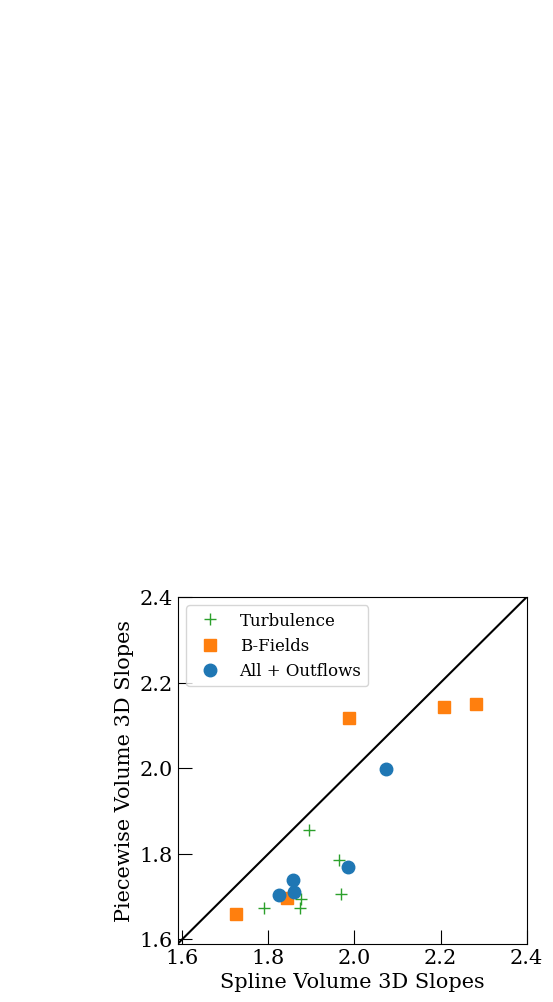

In [13]:
#2D graph of piecewise and spline slopes
#plot bells and whistles
plt.figure(figsize = (4.5,4.5))
#plot x = y line
x=.1*np.linspace(0,90)
y=x
plt.plot(x,y, color = 'black')
plt.errorbar(turbulence_3D_vol,slope_volPDF_gt,color = 'C2', fmt = '+', markersize = 9, label = 'Turbulence')
plt.errorbar(mag_3D_vol,slope_volPDF_gtm,color = 'C1', fmt = 's', markersize = 9, label = 'B-Fields')
plt.errorbar(outflows_3D_vol,slope_volPDF_gtmp,color = 'C0',  fmt = 'o', markersize = 9, label = 'All + Outflows')
#mark specific percent case
if num_runs == 1:
    plt.errorbar(turbulence_3D_vol[snap],slope_volPDF_gt[snap],color = 'black', fmt = '.', markersize = 9)
    plt.errorbar(mag_3D_vol[snap],slope_volPDF_gtm[snap],color = 'black', fmt = '.', markersize = 9)
    plt.errorbar(outflows_3D_vol[snap],slope_volPDF_gtmp[snap],color = 'black', fmt = '.', markersize = 9)

#bells n whistles
plt.xlabel('Spline Volume 3D Slopes', size=15)
plt.ylabel('Piecewise Volume 3D Slopes', size=15)
plt.ylim(1.59,2.4)
plt.xlim(1.59,2.4)
plt.annotate('3D Slopes', (1.2,3.75), color = 'black', fontsize =15, weight = 'bold',horizontalalignment='left',verticalalignment='center', textcoords='data', bbox=dict(facecolor='white', alpha=0.8))
plt.tick_params(direction='in', which = 'major', size =10, labelsize = 15)
plt.tick_params(direction='in', which = 'minor', size =4)
plt.legend(loc = 'upper left',fontsize = 12)
plt.tight_layout()

if num_runs == 1:
    plt.savefig('pipeline/'+ perc +'per_pipeline/3D_spline_v_piecewise_'+ perc+'_percent_slope_spline_pdFit.pdf', bbox_inches='tight', format = 'pdf')
else:
    plt.savefig('pipeline/3D_spline_v_piecewise.pdf', bbox_inches='tight', format = 'pdf')


<function matplotlib.pyplot.show(*args, **kw)>

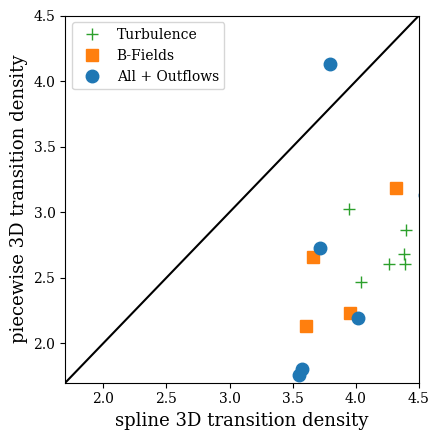

In [14]:
#main plotting cell
line = ('solid', 'dashed', 'dotted')
#inputfile = ('txt_file_storage/slope_0%_lim,5.txt','txt_file_storage/slope_1%_lim,5.txt','txt_file_storage/slope_2%_lim,5.txt','txt_file_storage/slope_3%_lim,5.txt','txt_file_storage/slope_4%_lim,5.txt','txt_file_storage/slope_5%_lim,5.txt')#,'slope_10%_and_6%.txt',)
inputfile = ('txt_file_storage/vol_trans_density0%.txt','txt_file_storage/vol_trans_density1%.txt','txt_file_storage/vol_trans_density2%.txt','txt_file_storage/vol_trans_density3%.txt','txt_file_storage/vol_trans_density4%.txt','txt_file_storage/vol_trans_density5%.txt')

plt.figure(figsize = (4.5,4.5))
trans_3D_g = []
trans_3D_gt = []
trans_3D_gtm = []
trans_3D_gtmp = []
for a in range(1):

    sfe = range(6)
    for ii in range(6):
        #slope cutting. data from txt file chopped into usable form.
        f =open(inputfile[ii])
        newlist = [i for i in f]
        string = newlist[0]
        string1 = string.split("[")[1]
        string2 = string1.split("]")[0]
        string3 = string2.split(",")
        string3 = np.array(string3)
        slope_list = string3.astype('float')
        trans_3D_gt.append(slope_list[0])
        trans_3D_gtm.append(slope_list[1])
        trans_3D_gtmp.append(slope_list[2])
     
    
inputfile = ('txt_file_storage/vol_trans_point0%.txt','txt_file_storage/vol_trans_point1%.txt','txt_file_storage/vol_trans_point2%.txt','txt_file_storage/vol_trans_point3%.txt','txt_file_storage/vol_trans_point4%.txt','txt_file_storage/vol_trans_point5%.txt')
trans_3D_spline_g = []
trans_3D_spline_gt = []
trans_3D_spline_gtm = []
trans_3D_spline_gtmp = []
for a in range(1):

    sfe = range(6)
    for ii in range(6):
        #slope cutting. data from txt file chopped into usable form.
        f =open(inputfile[ii])
        newlist = [i for i in f]
        string = newlist[0]
        string1 = string.split("[")[1]
        string2 = string1.split("]")[0]
        string3 = string2.split(",")
        string3 = np.array(string3)
        slope_list = string3.astype('float')
        trans_3D_spline_gt.append(slope_list[0])
        trans_3D_spline_gtm.append(slope_list[1])
        trans_3D_spline_gtmp.append(slope_list[2])
    x=.1*np.linspace(-10,80)
    y=x
plt.plot(x,y, color = 'black')
plt.errorbar(trans_3D_spline_gt,trans_3D_gt, fmt = "+", color = 'C2', label = 'Turbulence', markersize = 9)#, alpha =alpha[a])
plt.errorbar(trans_3D_spline_gtm, trans_3D_gtm, fmt = "s", color = 'C1', label = 'B-Fields', markersize = 9)#, alpha =alpha[a])
plt.errorbar(trans_3D_spline_gtmp, trans_3D_gtmp, fmt = "o", color = 'C0', label = 'All + Outflows', markersize = 9)#, alpha =alpha[a])
#mark points
if num_runs == 1:
    plt.errorbar(trans_3D_spline_gt[snap],trans_3D_gt[snap], marker = ".", color = 'black')#, alpha =alpha[a])
    plt.errorbar(trans_3D_spline_gtm[snap], trans_3D_gtm[snap], marker = ".", color = 'black')#, alpha =alpha[a])
    plt.errorbar(trans_3D_spline_gtmp[snap], trans_3D_gtmp[snap], marker = ".", color = 'black')#, alpha =alpha[a])

#bells n whistles
plt.xlabel(r'spline 3D transition density', size=13)
plt.xlim(1.7,4.5)
plt.ylim(1.7,4.5)
plt.ylabel(r'piecewise 3D transition density', size=13)
plt.legend()

plt.tight_layout()

if num_runs == 1:
    plt.savefig('pipeline/'+ perc +'per_pipeline/trans_density_comparision_'+ perc+'_percent_slope_spline_pdFit.pdf', bbox_inches='tight', format = 'pdf')
else:
    plt.savefig('pipeline/trans_density_comparision_super.pdf', bbox_inches='tight', format = 'pdf')
plt.show

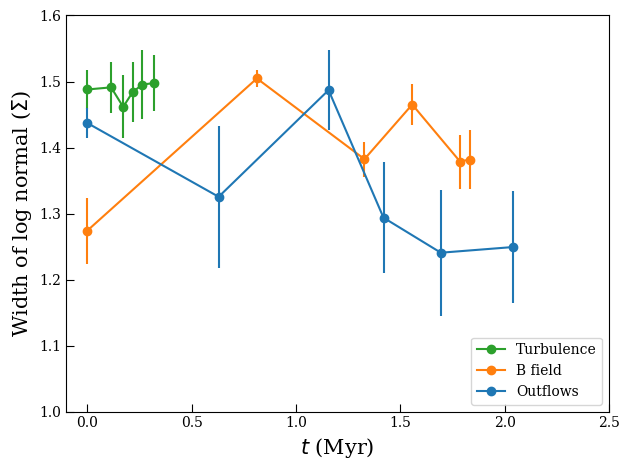

In [15]:
#wdith of log normal
#time
#importing timing and other files
inputfile = ('slope_0%.txt','slope_1%.txt','slope_2%.txt','slope_3%.txt','slope_4%.txt','slope_5%.txt')#,'slope_10%_and_6%.txt',)
time_file = pd.read_csv("Time_conversions.csv")
times = time_file['time']
times = times*3.71e-14   #convert seconds to Myear
time_gtmp =times[0:6]
time_gtmp = time_gtmp-time_gtmp[0]
time_gtm = times[7:13]
time_gtm = time_gtm-time_gtm[7]
time_gt = times[14:20]
time_gt = time_gt-time_gt[14]
time_g = times[21:27]
time_g = time_g-time_g[21]
#main plotting
plt.tick_params(direction='in', length=6)
#inputfile = ('txt_file_storage/sigma_0%.txt','txt_file_storage/sigma_1%.txt','txt_file_storage/sigma_2%.txt','txt_file_storage/sigma_3%.txt','txt_file_storage/sigma_4%.txt','txt_file_storage/sigma_5%.txt')
inputfile = ('txt_file_storage/vol_power_fit_sigma0%.txt','txt_file_storage/vol_power_fit_sigma1%.txt','txt_file_storage/vol_power_fit_sigma2%.txt','txt_file_storage/vol_power_fit_sigma3%.txt','txt_file_storage/vol_power_fit_sigma4%.txt','txt_file_storage/vol_power_fit_sigma5%.txt')

for a in range(1):
    slope_x_g = []
    slope_x_gt = []
    slope_x_gtm = []
    slope_x_gtmp = []
    error_x_g = []
    error_x_gt = []
    error_x_gtm = []
    error_x_gtmp = []
    sfe = range(6)
    for ii in range(6):
        #slope cutting. data from txt file chopped into usable form.
        f =open(inputfile[ii])
        newlist = [i for i in f]
        string = newlist[0]
        string1 = string.split("[")[1]
        string2 = string1.split("]")[0]
        string3 = string2.split(",")
        string3 = np.array(string3)
        slope_list = string3.astype('float')
        slope_x_gt.append(slope_list[0])
        slope_x_gtm.append(slope_list[1])
        slope_x_gtmp.append(slope_list[2])
        #error bar cutting
        f =open(inputfile[ii])
        newlist = [i for i in f]
        string = newlist[1]
        string1 = string.split("[")[1]
        string2 = string1.split("]")[0]
        string3 = string2.split(",")
        string3 = np.array(string3)
        slope_list = string3.astype('float')
        error_x_gt.append(slope_list[0])
        error_x_gtm.append(slope_list[1])
        error_x_gtmp.append(slope_list[2])
        
    plt.errorbar(time_gt,slope_x_gt,yerr = error_x_gt, marker = "o", color = 'C2', linestyle = line[a])#, alpha =alpha[a])
    plt.errorbar(time_gtm,slope_x_gtm,yerr = error_x_gtm, marker = "o", color = 'C1', linestyle = line[a])#, alpha =alpha[a])
    plt.errorbar(time_gtmp,slope_x_gtmp,yerr = error_x_gtmp, marker = "o", color = 'C0', linestyle = line[a])#, alpha =alpha[a])
    #Invisible lines to fix legend
    plt.plot(10,0, marker = "o", color = 'C2', linestyle = line[0])
    plt.plot(10,0, marker = "o", color = 'C1', linestyle = line[0])
    plt.plot(10,0, marker = "o", color = 'C0', linestyle = line[0])
    #plot bells and whistles
    #plt.title('Log Normal Sigma V.S. Time', size = 15)
    plt.xlabel(r'$t$ (Myr)', size=15)
    plt.ylabel(r'Width of log normal ($\Sigma$)', size=15)
    plt.ylim( 1,1.6)
    plt.xlim(-.1,2.5)
    plt.legend(['Turbulence', 'B field', 'Outflows'], loc = 'lower right')
plt.tight_layout()
plt.savefig('pipeline/sigma_piecewise.pdf', bbox_inches='tight', format = 'pdf')


In [4]:
slope_list

array([0.02936206, 0.04993506, 0.02280251])